In [1]:
import numpy as np
import wotan
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import binom,norm
import scipy
from scipy.special import factorial as factorial
import scipy.integrate as integrate
import lightkurve as lk # make sure this is the latest version, v.2.4 - you get it with pip install lightkurve
from lightkurve import search_targetpixelfile
from astropy.table import Table
import re
import os
import warnings

from astroquery.mast import Catalogs

# Let's also set some plotting parameters from the start that will a) make them look a bit prettier and
# b) stop us from having to write this code every single time we plot

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 16,
    'axes.labelsize': 'large',
    'mathtext.fontset': 'stix'
})

plt.style.use("dark_background")

# ADVISORY

This project will involve downloading like 15 GB of data onto your disk. If you ever find it to be too much go into your terminal and go to cd /Users/USERNAME/.lightkurve/cache/mastDownload/TESS

then enter ls
You'll see the list of all your lightcurves

Enter rm -r /Users/USERNAME/.lightkurve/cache/mastDownload/TESS

YOU MUST INCLUDE THE ENTIRE DIRECTORY OR ELSE YOU MAY DELETE YOUR ENTIRE DISK

This will free the disk space back up

# Why are we here?

# Making a Sample

For this project we'll be finding and parameterizing flares in stars in a large set of lightcurve data.  Unfortunately not all lightcurves are created equal. Some simply won't have any flares! One way we'll sus out which stars we should try to model will be to use some of the flags from the Petrucci data. They have flags telling us whether or not they see flares. If flares is marked 'Yes' it's pretty likely that they have nice, easy to model light curves with notable flares.

In [4]:
Petrucci_Data = Table.read('/Users/jasonreeves/Downloads/TESSData.csv', format = 'ascii.csv')

#we'll call them flare stars, stars with flares
#i think it's a pretty obvious name

flare_stars = Petrucci_Data['Flares'] == 'Yes'

flare_stars = Petrucci_Data[flare_stars]

print(flare_stars)

#I guess some of them are corrupted, we'll cut them
flare_stars = np.delete(flare_stars, np.array([7]))

  #TICID  Teff SpT  TESS sectors ... RVReference GalacticPopulation Probability
--------- ---- ---- ------------ ... ----------- ------------------ -----------
180724005 2648 M7.2       2,3,29 ...      SIMBAD          THIN-DISK       0.987
 70555405 2642 M7.3         3,30 ...      SIMBAD          THIN-DISK       0.934
142944290 2642 M7.3         4,31 ...      SIMBAD          THIN-DISK       0.988
298907057 2714 M6.8         5,32 ...      SIMBAD          THIN-DISK       0.988
461654150 2699 M6.9           20 ...      SIMBAD          THIN-DISK       0.986
  3664898 2791 M6.3           21 ...    GAIA-DR3          THIN-DISK       0.966
  7975441 2400   M9         8,34 ...      SIMBAD          THIN-DISK       0.987
293520468 2825   M6         8,35 ...      SIMBAD          THIN-DISK       0.984
902237947 2545   M8           36 ...      SIMBAD          THIN-DISK       0.983
334937178 2458 M8.6        10,36 ...      SIMBAD          THIN-DISK       0.987
      ...  ...  ...          ... ...    

Fit one of them for an example

/opt/anaconda3/lib/python3.12/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 18 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


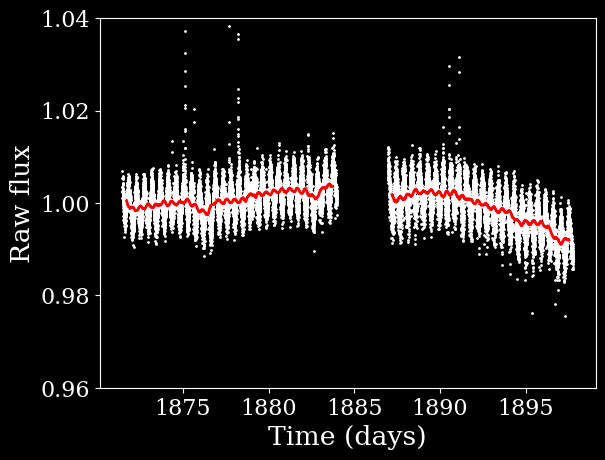

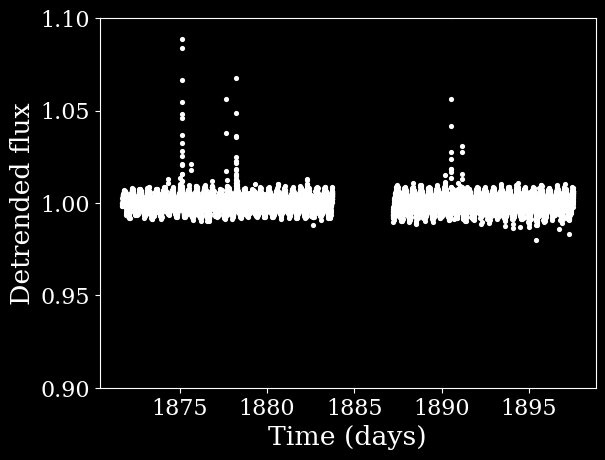

In [8]:
target = flare_stars['#TICID'][5]

tpf = search_targetpixelfile('TIC ' + str(target)).download()


lc = tpf.to_lightcurve()

good_points = lc.quality == 0

flux = lc.flux.value[good_points]

time = lc.time.value[good_points][np.isnan(flux) == False]

flux_err = lc['flux_err'].value[good_points][np.isnan(flux) == False]

flux = lc.flux.value[good_points][np.isnan(flux) == False]

median_flux = np.median(flux)

flatten_lc, trend_lc = wotan.flatten(time, flux/median_flux, window_length=0.5, return_trend=True, edge_cutoff=0.5)

plt.scatter(time, flux/median_flux, s=1, color='white')
plt.plot(time, trend_lc, linewidth=2, color='red')
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
plt.ylim(0.96, 1.04)
plt.show()

plt.scatter(time, flatten_lc, linewidth=2, color='white', s = 3)
plt.xlabel('Time (days)')
plt.ylabel('Detrended flux')
plt.ylim(0.9, 1.1)
plt.show()

# Clip out flares

We'll clip out flares and log their energies by flattening the light curves and picking out bright points that are a certain number of standard deviations from the median of the normalized flux. However this isn't enough, there may be a ton of points that are associated with the same flare. We only want one flare flux associated with one time. To cut out the redundant point we'll put them in an ordered list in descending order. We'll iterate through the list and check the times around the fluxes. If there are other points in this time bin we'll delete them from the array. By the end we should just have one point for the flares and their associated peak time.

First, let's find the sigma needed to clip out flares and a time window around the flares to clip out other points without overlapping other flares. Below is a portion of the flattened light curve of a target. We'll overlay a region a certain number of standard deviations, 3.5σ (or so, it changes with my mood), from the median. We'll also clip out a time segment I chose because 1) there are multiple fluxes associated with one flare and 2) there's a nearby flare we don't want to cut out.

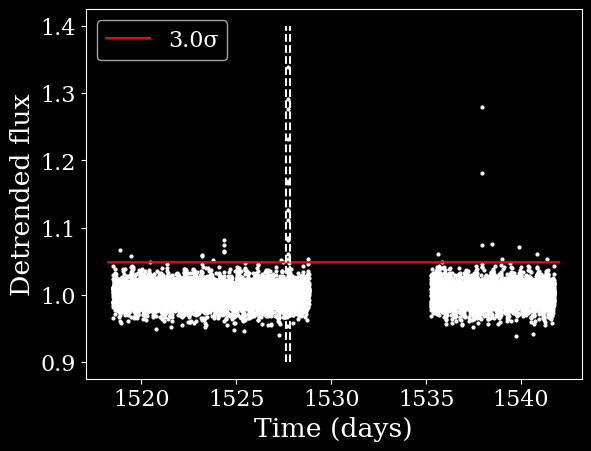

In [318]:
target = flare_stars['#TICID'][6]

tpf = search_targetpixelfile('TIC ' + str(target)).download()

lc = tpf.to_lightcurve()

good_points = lc.quality == 0

flux = lc.flux.value[good_points]

time = lc.time.value[good_points][np.isnan(flux) == False]

flux = lc.flux.value[good_points][np.isnan(flux) == False]

median_flux = np.nanmedian(flux/median_flux)

flatten_lc, trend_lc = wotan.flatten(time, flux/median_flux, window_length=0.5, return_trend=True, edge_cutoff=0.5)

flux_std = np.nanstd(flatten_lc)

#this is our magic flare std, anything this number of sigma from 1 is for sure a flare
#measured by eye
magic_flare_std = 3.0

#this is half the width of the time window
flare_time_window = 0.07

plt.scatter(time, flatten_lc, linewidth=2, color='white', s = 1)
plt.plot(time, time * 0 + 1 + magic_flare_std * flux_std, color = 'red', label = str(magic_flare_std) + 'σ')
plt.vlines(1527.8, 0.9, 1.4, linestyle = '--')
plt.vlines(1527.6, 0.9, 1.4, linestyle = '--')
plt.xlabel('Time (days)')
plt.ylabel('Detrended flux')
#plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper left')

In [585]:
#this is the threshold over which we consider something a flare

magic_flare_std = 3.0

def flare_finder(lightcurve):

    #unpack array

    time = lightcurve[0]

    flux = lightcurve[1]

    quality = lightcurve[2]

    #cut out the crap points using quality flags

    perfect_points = quality == 0

    #unpack good values of flux and time for the star

    flux = flux[perfect_points]

    time = time[perfect_points][np.isnan(flux) == False]

    flux = flux[np.isnan(flux) == False]

    #normalize the normalized flux to one

    normalized_flux = flux/np.nanmedian(flux)

    #detrend the light curve with wotan

    normalized_flux = wotan.flatten(time, normalized_flux, window_length=0.1, return_trend=False, edge_cutoff=0.5)

    #find the standard deviation to sus out the potential flares

    flux_std = np.nanstd(normalized_flux)

    #identify really bright fluxes and their associated times a certain number of
    #standard deviations from the median

    #There ARE redundant fluxes in these measurements, we'll need to filter those out

    flux_threshold = 1 + (magic_flare_std * flux_std)

    flare_candidates = normalized_flux[normalized_flux > flux_threshold]

    time_candidates = time[normalized_flux > flux_threshold]

    #sort them in descending order with highest fluxes first

    #ready for this shit?

    #we call three separate numpy functions to sort the times
    #we want it so that we preserve the times corresponding to each flare canditate
    #once the flares are sorted. searchsorted tells us the indices of the sorted array of
    #flare candidates and thus the corresponding indices of the times. We then need to reverse
    #to be in descending order

    time_candidates = np.flip(time_candidates[np.argsort(flare_candidates)])

    flare_candidates = np.flip(np.sort(flare_candidates))

    #empty array to hold the flare equivalent durations

    flare_equivalent_durations = []

    #flare end times

    flare_end_times = []
    
    #Alright, let's filter through these arrays and get rid of the redundant measurements
    #We'll run through it until a certain break condition

    flare_time_window = 0.05 #days

    i = 0

    #So basically we're going to go through the list from the largest fluxes down
    #if there are other listed candidates near the flux we're testing they're probably a part of this
    #flare

    while i < len(time_candidates):

        #this guy is for SURE a flare
        flare_flux = flare_candidates[i]

        #this is the associated time
        flare_time = time_candidates[i]
        

        #look around this time to see if any of the time candidates are in the window
        redundant_points = np.where((time_candidates < flare_time + flare_time_window) &
                                   (time_candidates > flare_time - flare_time_window) &
                                    (time_candidates != flare_time))[0]

        #See if we should keep the flare if there are two more points around it
        #if there are less than two redundant points it's probably noise and we should
        #dump it

        if len(redundant_points) < 2:

             sufficient_points = False

        else:

            #to further prevent random noise, let's make sure these extra points are to the
            #right at higher time coords in consecutive order

            where_flare_time = np.where((time == flare_time))[0]

            flux_threshold = 1 + (magic_flare_std * flux_std)

            if ((normalized_flux[where_flare_time] > flux_threshold) &
                (normalized_flux[where_flare_time + 1] > flux_threshold) &
                (normalized_flux[where_flare_time + 2] > flux_threshold)):

                #And we want decay, all the points have to exponentionally fall off
                #check for negative slopes

                if ((normalized_flux[where_flare_time + 2] - normalized_flux[where_flare_time + 1] < 0) &
                    (normalized_flux[where_flare_time + 1] - normalized_flux[where_flare_time] < 0)):

                    sufficient_points = True

                else:

                    sufficient_points = False

            else:

                #I mean, hey, if the peak is above 6σ it's probably a flare
                #I've noticed a few where the buildup is caught but the decay isn't

                if flare_flux > 1 + (6 * flux_std):

                    sufficient_points = True

                
                else:
                    
                    sufficient_points = False

        ###############CHECK FOR NOISE##############

        #Maybe it was a bad day for the telescope, check the noise the day around
        #the flare detection and quantify how bad it is

        #since 3σ covers 99.73% of the data we expect 0.135% to just jump below 3σ in a given time
        #if there significantly more than that it's crap data

        #time cadence
        dt = np.median(np.diff(time))

        dt = 0.00139

        #find number of flux points in 0.25 day window 
        number_points = 0.25 / dt

        #number of points we expect to find below the threshold
        number_outliers_expected = (1 - scipy.stats.norm.cdf(magic_flare_std)/2) * number_points


        #number of actual outliers

        outlier_fluxes = len(np.where((time < flare_time + 0.25) &
                                      (time > flare_time - 0.25) &
                                      (normalized_flux < 1 - (magic_flare_std * flux_std)))[0])

        #If there is a lot of noise clustered around one area of the light curve
        #the standard deviation will be lower compared to that region so we're underestimating the
        #expected outliers just a tad but that's okay

        if (outlier_fluxes < number_outliers_expected):

            noise_resistant = True

        else:
            noise_resistant = False

        #If it IS a real flare
        #delete these redundant points in the arrays

        if (sufficient_points == True) & (noise_resistant == True):

            #find the flare energy by subtracting 1 from each point to elliminate the underlying
            #continuum and integrate between the points
            #we'll approximate the area between points as a trapazoid with bases equal to fluxes
            #and height equal to difference in time coords
        
            
            #Find all the times consecutively before and after the flare that are above threshold

            where_flare_time = np.where(time == flare_time)[0]

            #find all the points building up to flare peak

            index_left_of_peak = 0

            while normalized_flux[where_flare_time - index_left_of_peak] > flux_threshold:

                index_left_of_peak -= 1

            #Find the exact index in time where the flare starts so we can us np.trapz later

            flare_time_start_index = int(where_flare_time + index_left_of_peak)

            #Find the time here corresponding to starting time

            flare_start_time = time[flare_time_start_index]

            #find all the points after the peak

            index_right_of_peak = 0

            while normalized_flux[where_flare_time + index_right_of_peak] > flux_threshold:

                index_right_of_peak += 1

            #Find the exact index in time where the flare ends so we can us np.trapz later

            flare_time_end_index = int(where_flare_time + index_right_of_peak)

            #Find the time here corresponding to ending time

            flare_end_time = time[index_right_of_peak]

            #find area under curve as equivalent duration using trapezoidal rule

            #Subract one to isolate contribution from flare

            equivalent_duration = np.trapz(normalized_flux[flare_time_start_index:flare_time_end_index] - 1,
                                           x = time[flare_time_start_index:flare_time_end_index])

            #covert to seconds

            days_to_seconds = 86400

            equivalent_duration = equivalent_duration * 86400



            ##### DELETE REDUNDANT POINTS BELONGING TO SAME FLARE########

            time_candidates = np.delete(time_candidates, redundant_points)

            flare_candidates = np.delete(flare_candidates, redundant_points)

            flare_equivalent_durations.append(equivalent_duration)

            i = i + 1

        #if it's not a true flare
        
        else:

            time_candidates = np.delete(time_candidates, i)

            flare_candidates = np.delete(flare_candidates, i)

            #key point, DONT increase the index, we're tossing
            #out this data point so we want to re-evaluate the index i

            i = i
        
        #condition to break, if the next iteration will have an i that is out of
        #range of the array, we'll end the for loop

        if i >= (len(time_candidates)):

            break

    #convert EDs to numpy array

    flare_equivalent_durations = np.array(flare_equivalent_durations)

    #subtract one from the flare flux areas to isolate amplitude of flare alone

    flare_candidates = flare_candidates - 1

    flare_end_times = np.array(flare_end_times)

    return time_candidates, flare_candidates, flare_equivalent_durations, flare_end_times

    

# Light Curves For Presentation

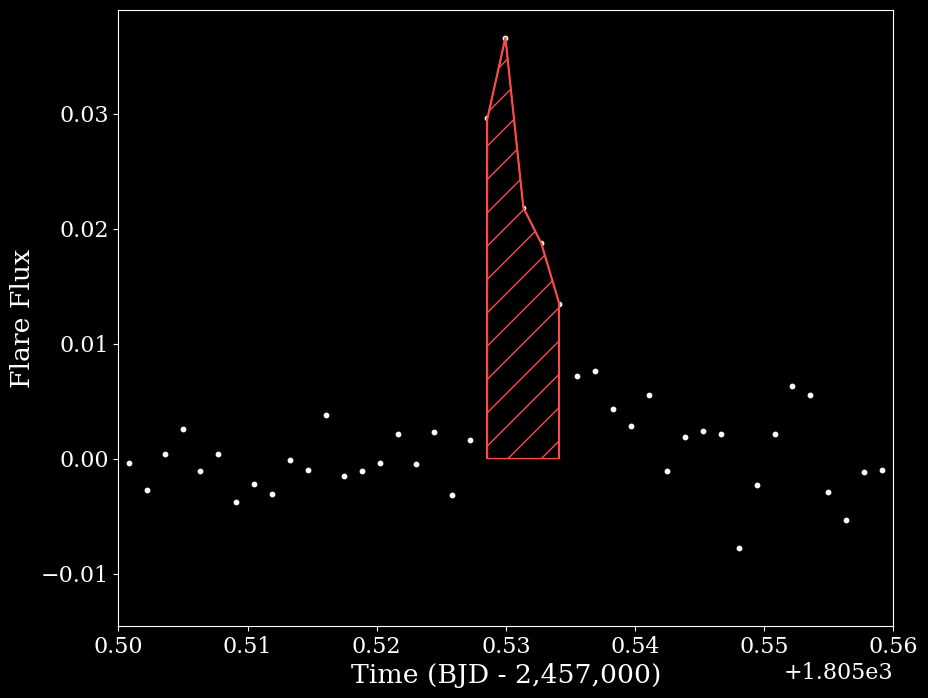

In [588]:
magic_flare_std = 3.0

#Import file in question

target_pixel_file = search_targetpixelfile('TIC 420130591', mission = 'TESS', sector = 18)[0].download()

light_curve = target_pixel_file.to_lightcurve()

#dissect values

flux = light_curve.flux.value[light_curve.quality == 0]

time_t = light_curve.time.value[light_curve.quality == 0][np.isnan(flux) == False]

flux = light_curve.flux.value[light_curve.quality == 0][np.isnan(flux) == False]


#normalize flux

normalized_flux = flux/np.nanmedian(flux)

#wotan time!

flatten_lc, trend_lc = wotan.flatten(time_t, normalized_flux, window_length=0.05, return_trend=True, edge_cutoff = 0.5)

#find std so we can plot what the threshold looks like

flux_std = np.nanstd(flatten_lc)


#repackage the light curve data so we can run flare finder to prove we DON'T
#Accidentally recover any flares

time = light_curve.time.value

flux = light_curve.flux.value

quality = light_curve.quality.value

light_curve = np.array([time, flux, quality])

flare_times, flare_amps, flare_EDs, flare_end_times = flare_finder(light_curve)


#Plot

plt.figure(figsize = (10,8))

time_array = np.linspace(min(time) - 10, max(time) + 10, 100)

plt.scatter(time_t, flatten_lc - 1, color = 'white', s = 10)
plt.plot(time_t[(time_t > 1805.5275) & (time_t < 1805.535)],
         flatten_lc[(time_t > 1805.5275) & (time_t < 1805.535)] - 1, color = '#FE4A49')
plt.vlines(time_t[(time_t > 1805.533) & (time_t < 1805.535)], 0,
           flatten_lc[(time_t > 1805.533) & (time_t < 1805.535)] - 1, color = '#FE4A49')

plt.vlines(time_t[(time_t > 1805.5275) & (time_t < 1805.5295)], 0,
           flatten_lc[(time_t > 1805.5275) & (time_t < 1805.5295)] - 1, color = '#FE4A49')

plt.fill_between(time_t[(time_t > 1805.5275) & (time_t < 1805.535)], 0,
                 flatten_lc[(time_t > 1805.5275) & (time_t < 1805.535)] - 1, hatch = '/', 
                 edgecolor = '#FE4A49', facecolor = 'black')
#plt.scatter(flare_times, flare_amps, marker = '*', color = 'red', label = 'Flares')
#plt.vlines(flare_times + 0.15, 1.12, 1., color = 'grey', linestyle = '--')
#plt.vlines(flare_times - 0.15, 1.12, 1., color = 'grey', linestyle = '--')
#plt.plot(time, time * 0 + 1 + (3.0 * flux_std), color = 'red', label = str(magic_flare_std) + 'σ')
plt.xlabel('Time (BJD - 2,457,000)')
plt.ylabel('Flare Flux')
#plt.title('TIC ' + str(420130591))
#plt.ylim(0.96, 1.075)
plt.xlim(1805.5, 1805.56)
#plt.legend()
plt.show()

I would like to show off a light curve with one of these "inverse flares." Objects with a lot of noise that we don't want to confuse with flares.

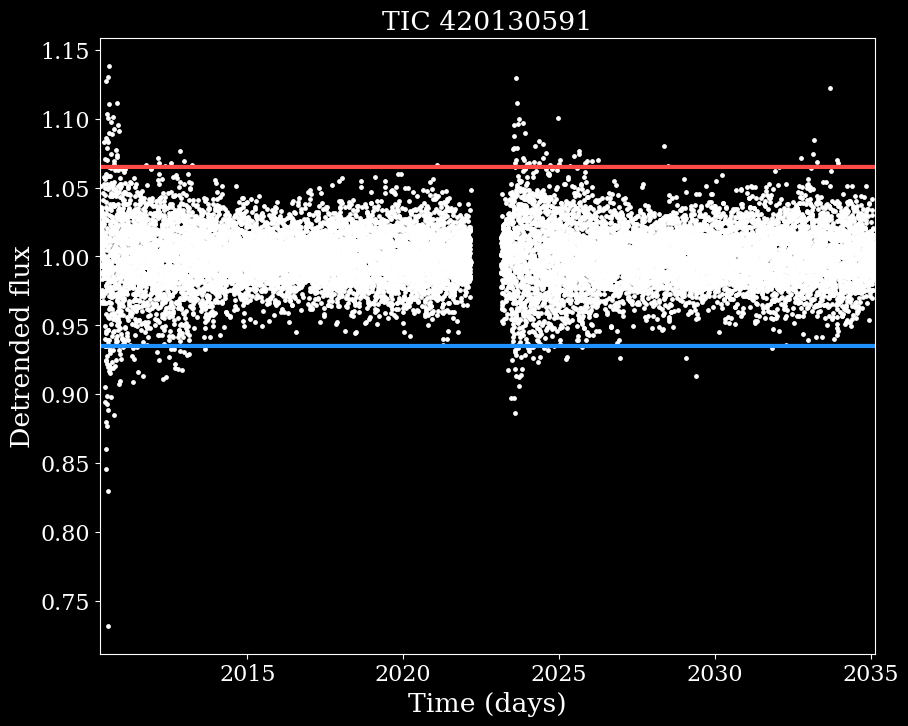

In [591]:
# Sectors available
# 14,15,16,17,18,19,20,21,22,23,24,25,26,40,41,47,48,49,50,51,52,53


magic_flare_std = 3.0

#Import file in question

target_pixel_file = search_targetpixelfile('TIC 420130591', mission = 'TESS', sector = 26)[0].download()

light_curve = target_pixel_file.to_lightcurve()

#dissect values

flux = light_curve.flux.value[light_curve.quality == 0]

time_t = light_curve.time.value[light_curve.quality == 0][np.isnan(flux) == False]

flux = light_curve.flux.value[light_curve.quality == 0][np.isnan(flux) == False]


#normalize flux

normalized_flux = flux/np.nanmedian(flux)

#wotan time!

flatten_lc, trend_lc = wotan.flatten(time_t, normalized_flux, window_length=0.05, return_trend=True, edge_cutoff = 0.5)

#find std so we can plot what the threshold looks like

flux_std = np.nanstd(flatten_lc)


#repackage the light curve data so we can run flare finder to prove we DON'T
#Accidentally recover any flares

time = light_curve.time.value

flux = light_curve.flux.value

quality = light_curve.quality.value

light_curve = np.array([time, flux, quality])

flare_times, flare_amps, flare_EDs, flare_end_times = flare_finder(light_curve)


#Plot

plt.figure(figsize = (10,8))

plt.scatter(time_t, flatten_lc, color = 'white', s = 6, label = 'Quality Points')
plt.scatter(flare_times, 1+flare_amps, marker = '*', color = 'red', label = 'Flares')
#plt.vlines(flare_times + 0.15, 0.98, max(flare_amps) + 1, color = 'black', linestyle = '--')
#plt.vlines(flare_times - 0.15, 0.98, max(flare_amps) + 1, color = 'black', linestyle = '--')
plt.plot(time, time * 0 + 1 + (magic_flare_std * flux_std), color = '#FE4A49',
         linewidth = 3, label = str(magic_flare_std) + 'σ')
plt.plot(time, time * 0 + 1 - (magic_flare_std * flux_std), color = 'dodgerblue',
         linewidth = 3, label = str(-magic_flare_std) + 'σ')
plt.xlabel('Time (days)')
plt.ylabel('Detrended flux')
plt.title('TIC ' + str(420130591))
plt.xlim(min(time), max(time))
#plt.xlim(2630.63, 2630.635)
#plt.legend()
plt.show()

In [593]:
warnings.filterwarnings("ignore")


def flare_energy_calc(star_luminosity, equivalent_duration):

    c = 0.19 #value adopted from Petrucci etal 2024

    #YES, I KNOW THEY SAY IT'S 0.19 BUT THAT'S JUST NOT TRUE
    #I CHECKED THEIR NUMBERS AND C MUST BE 1. WHYYYYYYY?

    equivalent_duration_secs = equivalent_duration

    #equation used in Petrucci etal 2024

    flare_energy = equivalent_duration_secs * star_luminosity / c #in erg/s

    return flare_energy

#find the total amount of time
#of observation

#first we need to make a code to figure out the breaks between quality points


def time_of_obs(lightcurve):

    #Unpack

    time = lightcurve[0]

    flux = lightcurve[1]

    quality = lightcurve[2]

    #cut out the crap points using quality flags

    perfect_points = quality == 0

    #unpack good values of time for the star
    
    flux = flux[quality == 0]

    time = time[perfect_points][np.isnan(flux) == False]

    #find the differences of all the time coordinates

    time_diffs = np.append(False, np.diff(time) > 0.1)

    #find where that break is, this will tabulate the right hand side of the break(s)

    end_of_time_break = np.where(time_diffs == True)[0]

    #and the duration of the break(s)

    length_of_break = time[end_of_time_break] - time[end_of_time_break - 1]

    #total amount of time of observation

    time_of_observation = max(time) - min(time) - np.sum(length_of_break)

    return time_of_observation

Let's take object 420130591 (or object 420 as I call it). It has a lot of data and thus a lot of flares. We'll see how well our code stack up to the results from Petrucci.

In [598]:
#Isolate one single object to compare flares

single_flare_energies = np.array([])

ED_s = np.array([[],[],[],[]])

tpfs = search_targetpixelfile('TIC 420130591', mission = 'TESS').download_all()

lum = 5.128 * 10**30 #erg/s

#We'll only look at the sectors they analyze in the paper

for i in range(25):

    light_curve = tpfs[i].to_lightcurve()

    time = light_curve.time.value

    flux = light_curve.flux.value

    quality = light_curve.quality.value

    light_curve = np.array([time, flux, quality])

    ED_s = np.append(ED_s, np.array(flare_finder(light_curve)), axis = 1)

    single_flare_energies = np.append(single_flare_energies,
                                      np.array(flare_energy_calc(lum, flare_finder(light_curve)[2])), axis = 0)


ED_s = np.concatenate((ED_s, np.array([single_flare_energies])), axis = 0)

###ONE FINAL CHECK###
    #For some reason some duplicates sneak through, I can't seem to catch them in the 
    #first condition no matter what I do, so this time I'm just gonna order all the flares
    #in chronological order and cut out the ones that occur with in the same quarter of a day

ED_s[1] = ED_s[1][np.argsort(ED_s[0])]

ED_s[2] = ED_s[2][np.argsort(ED_s[0])]

ED_s[3] = ED_s[3][np.argsort(ED_s[0])]

ED_s[4] = ED_s[4][np.argsort(ED_s[0])]

ED_s[0] = np.sort(ED_s[0])

#find duplicate flares

flare_dupes = np.append(False, np.diff(ED_s[0]) < 0.1)

flare_dupes = np.where((flare_dupes == True))[0]

for index in flare_dupes:

    #We'll compare the two values to see which has a larger ED

    if ED_s[3][index] > ED_s[3][index - 1]:

        #delete the smaller one

        ED_s = np.delete(ED_s, index - 1, axis = 1)

    else:

        ED_s = np.delete(ED_s, index, axis = 1)

#convert to table in the right order

Object_420_flares = np.array([np.flip(ED_s[0][np.argsort(ED_s[2])]),np.flip(ED_s[3][np.argsort(ED_s[2])]),
                              np.flip(np.sort(ED_s[2])),np.flip(ED_s[1][np.argsort(ED_s[2])])])

print(Object_420_flares)


[[2.39411099e+03 2.63579080e+03 1.82711881e+03 1.82040356e+03
  2.43765330e+03 1.84536171e+03 1.80552996e+03 2.41416958e+03
  2.44397147e+03 1.84059371e+03 2.58794456e+03 2.58794421e+03
  2.43765434e+03 2.41416923e+03 2.75270949e+03 2.65768089e+03
  2.63082377e+03 2.71252121e+03 2.39617895e+03 1.97411243e+03
  1.80355635e+03]
 [2.39412349e+03 2.63583409e+03 1.82712714e+03 1.82041189e+03
  2.43766580e+03 1.84537421e+03 1.80555218e+03 2.41418347e+03
  2.44398397e+03 1.84060204e+03 2.58795151e+03 2.58795139e+03
  2.43766152e+03 2.41418219e+03 2.75271157e+03 2.65768274e+03
  2.63082492e+03 2.71256588e+03 2.39618589e+03 1.97411521e+03
  1.80355913e+03]
 [4.60168623e+01 2.67330717e+01 2.44502202e+01 2.43886153e+01
  2.19591245e+01 2.07494900e+01 1.84547178e+01 1.82794732e+01
  1.79174383e+01 1.57722184e+01 1.23633062e+01 1.19349733e+01
  1.15464011e+01 8.93048672e+00 6.74571563e+00 6.38151685e+00
  6.14458320e+00 6.09034823e+00 4.67432997e+00 3.80282830e+00
  3.03512547e+00]
 [1.92978732e-01

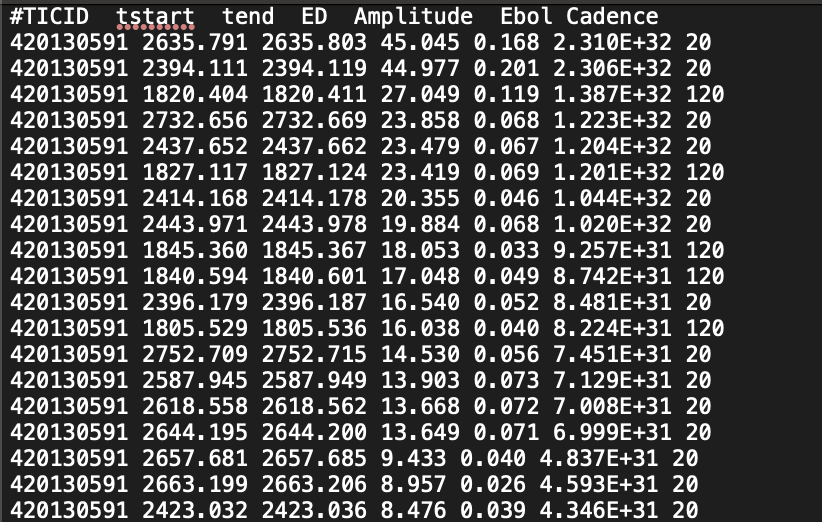

I visually checked all these TESS sectors and mine look great. It looks like there were a couple sectors they didn't find any flares where I found a few and a couple sectors where I found a flare they missed. In total I got 25 flares.

Now we need to divide these occurrences by the total amount of observation time. We'd need to make sure to subtract out the breaks in the measurements. We can do this using np.diff which can tell us when time coordinate are separated by more than 0.2 days

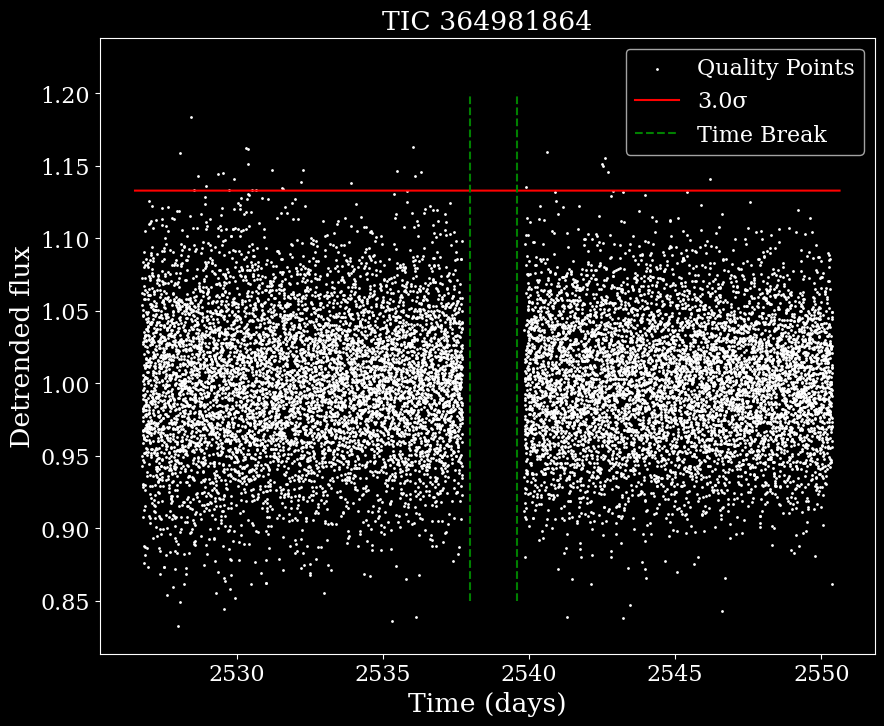

In [602]:
target = flare_stars['#TICID'][94]

target_pixel_file = search_targetpixelfile('TIC ' + str(target)).download_all()

light_curve = target_pixel_file[0].to_lightcurve()

flux = light_curve.flux.value[light_curve.quality == 0]

time = light_curve.time.value[light_curve.quality == 0][np.isnan(flux) == False]

flux = light_curve.flux.value[light_curve.quality == 0][np.isnan(flux) == False]

normalized_flux = flux/np.nanmedian(flux)

flatten_lc, trend_lc = wotan.flatten(time, flux/median_flux, window_length=0.5, return_trend=True, edge_cutoff=0.5)

flux_std = np.nanstd(flatten_lc)

#find the time breaks

#np.diff returns a boolean array one index shorter, so we'll start it with a False
#value so the difference array is the same size as the time array
#I want to convert the boolean array to an index so I can subtract the time coordinate of the right
#hand side of the break by the left hand side. Take my word for it, you can't do it with the boolean array
#but np.where is only one extra line and tells use the left and right hand sides of the breaks

time_diffs = np.append(False, np.diff(time) > 0.2)

time_breaks = np.where(time_diffs == True)[0]

plt.figure(figsize = (10,8))

plt.scatter(time, flatten_lc, color = 'white', s = 1, label = 'Quality Points')
plt.plot(time, time * 0 + 1 + (magic_flare_std * flux_std), color = 'red', label = str(magic_flare_std) + 'σ')
plt.vlines(time[time_breaks - 1], 0.85, 1.2, linestyle = '--', color = 'green', label = 'Time Break')
plt.vlines(time[time_breaks + 1], 0.85, 1.2, linestyle = '--', color = 'green')
plt.xlabel('Time (days)')
plt.ylabel('Detrended flux')
plt.title('TIC ' + str(target))
#plt.xlim(1520, 1529)
plt.legend()
plt.show()

Maybe not PERFECT, but close enough to the edges. Now we need to add them all up

# Download all the lightcurves with flares

We can do this such that we download ALL the light curves, some of which won't have light curves with flares. OR we can download only the light curves with flares to our local disk and call them. It reduces the time by like an order of magnitude so I'd say it's worth it. Below is a code to download all the relevant light curve data: the times, fluxes, and quality of points. Note the structure of the file naming preserves the tic and sector tpfs index in case we want to return to it later. Maybe I should've labeled it by the TESS Sector for better description. But you can do that, I've already downloaded everyhing.

In the next cell we'll read off the title of the file to get back the TIC to match each light curve with the spectral type and luminosity of the star in question. We'll be limiting the sample to only the specific sectors from Petrucci. There is additional data available and although it's tempting to incorporate more data for the sake of focusing this section to recreating their results with their data we should try to limit our scope.

NOTE: Sometimes when running a warning message may come up saying "No Data Found For Target 'TIC XXXXX'". As far as I can tell this means that for some sectors there's some corrupted data. The if type(tpf) != type(None) makes it so that if the data is corrupted it doesn't crash the loop but the data will be missed.

In [ ]:
#first dimension is the TESS object

#second dimension is the time, flux, quality



for i in range(len(flare_stars)):

    #identify the star in question
    star = flare_stars['#TICID'][i]

    for j in range(len(re.findall("(\d+)", flare_stars['TESS sectors'][i]))):

        #find the sector as an integer
        TESS_sector = int(re.findall("(\d+)", flare_stars['TESS sectors'][i])[j])

        tpf = search_targetpixelfile('TIC ' + str(star), mission = 'TESS',
                                     sector = TESS_sector).download()

        if type(tpf) != type(None):

            #get the lightcurve

            light_curve = tpf.to_lightcurve()

            time = light_curve.time.value

            flux = light_curve.flux.value

            quality = light_curve.quality.value

            light_curve = np.array([time, flux, quality])

            #find the flares

            flare_EDs = flare_finder(light_curve)[2]

            #if this lightcurve has flares

            if len(flare_EDs) > 0:

                #add this light curve to the file

                Petrucci_Light_Curves = np.asarray([time,flux,quality])

                path = '/Users/jasonreeves/Documents/AST 151 - Graduate Astro Lab/Assignment_5/Petrucci_Light_Curves_Sector_Limited/'
                
                file_path = (path + 'Petrucci_Light_Curves_' + str(star) + '_' + str(j) + '.csv')

                np.savetxt(file_path, Petrucci_Light_Curves, delimiter=',')

# Find all the flares

Using the folder we created (I called mine Petrucci_Light_Curves) we can use the os to go through and iteratively open them. We can also use the re module which can sort through a bit of string and tell us the numbers in there, of which we only want the first indexed one which has the TIC number.

We'll then keep iterating and use the flare finder and calculate the energies of the flares. Why didn't I just download the flares? Because I don't think my flare finder is perfect (yet). I wanted a way to skip downloading all the lightcurves which is the most computationally intensive part but still toy with the algorithm.

In [604]:
warnings.filterwarnings("ignore")
#great, now we just need to do it for all our stars and sort their spectral types

path = '/Users/jasonreeves/Documents/AST 151 - Graduate Astro Lab/Assignment_5/Petrucci_Light_Curves_Sector_Limited/'

ED_s = np.array([[],[],[],[]])

flare_energies_high_temp = np.array([])

flare_energies_mid_temp = np.array([])

flare_energies_low_temp = np.array([])

#and an array with all of them, for fun

flare_energies = np.array([])

#running tally of observation time in systems with observed flares

total_time_of_observation = 0

time_of_observation_high_temp = 0

time_of_observation_mid_temp = 0

time_of_observation_low_temp = 0

    
for name in os.listdir(path):

    #sometimes bunk files get caught up in the directory so we're gonna check to see
    #if the file starts with 'P'

    if name[0] == 'P':
        
        #import light curve from folder
        light_curve = np.genfromtxt(path + name, delimiter = ',')
    
        #find which index this is in the Petrucci data for Luminosity and Spectral Class
        #Find TIC number

        TIC_number = re.findall("(\d+)", name)[0]
        
        Petrucci_index = flare_stars['#TICID'] == int(TIC_number)
    
        #Find Luminosity
    
        L_bol = flare_stars['Lbol'][Petrucci_index] #Quiescent Lum in erg/s
    
        #And Spectral Type
        
        #returns  spec class as string
        #first indexed value of these strings are the leading number of class
    
        spec_class = flare_stars['SpT'][Petrucci_index][0]
    
        #find the flares
    
        flare_EDs = flare_finder(light_curve)[2]
                
        ED_s = np.append(ED_s, flare_finder(light_curve), axis = 1)
    
        if len(flare_EDs) > 0:
    
            #find the energies
    
            flare_Es = flare_energy_calc(L_bol, flare_EDs)
    
            #add to appropriate bin based on spectral class
    
            #low temp stuff
    
            if int(spec_class[1]) == 8 or int(spec_class[1]) == 9 or int(spec_class[1]) == 0: 
    
                flare_energies_low_temp = np.append(flare_energies_low_temp, flare_Es)
    
                time_of_observation_low_temp = time_of_observation_low_temp + time_of_obs(light_curve)
    
                #mid temp stuff
    
            elif int(spec_class[1]) == 6 or int(spec_class[1]) == 7:
    
                flare_energies_mid_temp = np.append(flare_energies_mid_temp, flare_Es)
    
                time_of_observation_mid_temp = time_of_observation_mid_temp + time_of_obs(light_curve)
    
                 #high temp studd
    
            elif int(spec_class[1]) == 4 or int(spec_class[1]) == 5:
    
                flare_energies_high_temp = np.append(flare_energies_high_temp, flare_Es)
    
                time_of_observation_high_temp = time_of_observation_high_temp + time_of_obs(light_curve)
    
                #unknown stuff
    
            else:
    
                print('I dont know what you want me to do, man')
    
                #everything
                
            flare_energies = np.append(flare_energies, flare_Es)
    
            #add to tally of total observation time
                    
            total_time_of_observation = total_time_of_observation + time_of_obs(light_curve)


ED_s = np.concatenate((ED_s, np.array([flare_energies])), axis = 0)

flare_energies = ED_s[4]

# Version if you WANT to import everything

It will take like 30 minutes to run on normal network speeds.

In [ ]:
warnings.filterwarnings("ignore")
#great, now we just need to do it for all our stars and sort their spectral types

ED_s = np.array([[],[],[],[]])

flare_energies_high_temp = np.array([])

flare_energies_mid_temp = np.array([])

flare_energies_low_temp = np.array([])

#and an array with all of them, for fun

flare_energies = np.array([])

#running tally of observation time in systems with observed flares

total_time_of_observation = 0

time_of_observation_high_temp = 0

time_of_observation_mid_temp = 0

time_of_observation_low_temp = 0
    
for i in range(len(flare_stars)):

    #identify the star in question
    star = flare_stars['#TICID'][i]

    tpfs = search_targetpixelfile('TIC ' + str(star)).download_all()

    if type(tpfs) != type(None):

        for j in range(len(tpfs)):

            light_curve = tpfs[j].to_lightcurve()

            #repackage it for the functions
            
            time = light_curve.time.value

            flux = light_curve.flux.value

            quality = light_curve.quality.value

            light_curve = np.array([time, flux, quality])

            #find the flares

            flare_EDs = flare_finder(light_curve)[2]
            
            ED_s = np.append(ED_s, flare_finder(light_curve), axis = 1)

            if len(flare_EDs) > 0:

                #find the energies

                L_bol = flare_stars['Lbol'][i] #quiescent lum of star in erg/s

                flare_Es = flare_energy_calc(L_bol, flare_EDs)

            #add to appropriate bin based on spectral class

            #returns  spec class as string
            #first indexed value of these strings are the leading number of class

                spec_class = flare_stars['SpT'][i]

            #low temp stuff

                if int(spec_class[1]) == 8 or int(spec_class[1]) == 9 or int(spec_class[1]) == 0: 

                    flare_energies_low_temp = np.append(flare_energies_low_temp, flare_Es)

                    time_of_observation_low_temp = time_of_observation_low_temp + time_of_obs(light_curve)

            #mid temp stuff

                elif int(spec_class[1]) == 6 or int(spec_class[1]) == 7:

                    flare_energies_mid_temp = np.append(flare_energies_mid_temp, flare_Es)

                    time_of_observation_mid_temp = time_of_observation_mid_temp + time_of_obs(light_curve)

             #high temp studd

                elif int(spec_class[1]) == 4 or int(spec_class[1]) == 5:

                    flare_energies_high_temp = np.append(flare_energies_high_temp, flare_Es)

                    time_of_observation_high_temp = time_of_observation_high_temp + time_of_obs(light_curve)

            #unknown stuff

                else:

                    print('I dont know what you want me to do, man')

            #everything
            
                flare_energies = np.append(flare_energies, flare_Es)

            #add to tally of total observation time
                
                total_time_of_observation = total_time_of_observation + time_of_obs(light_curve)


ED_s = np.concatenate((ED_s, np.array([flare_energies])), axis = 0)

flare_energies = ED_s[4]

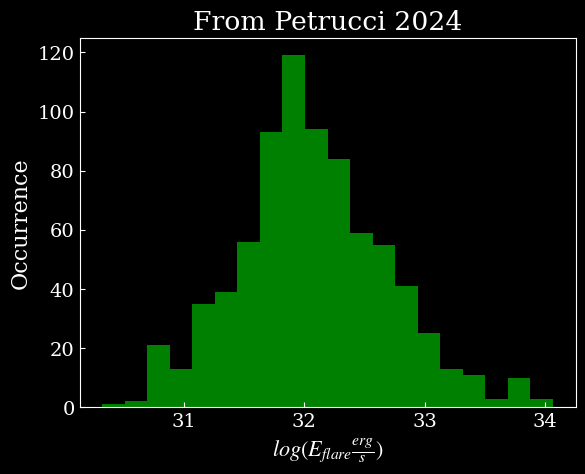

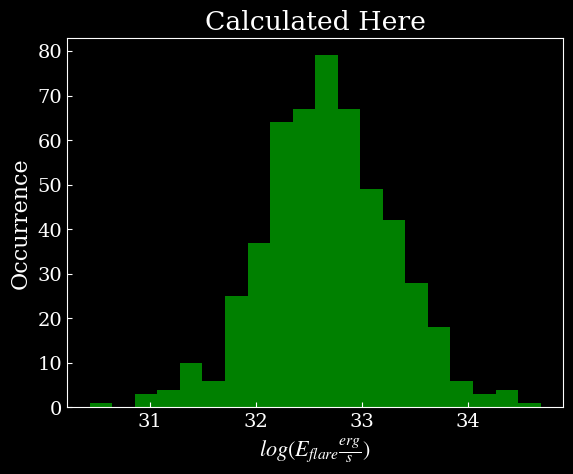

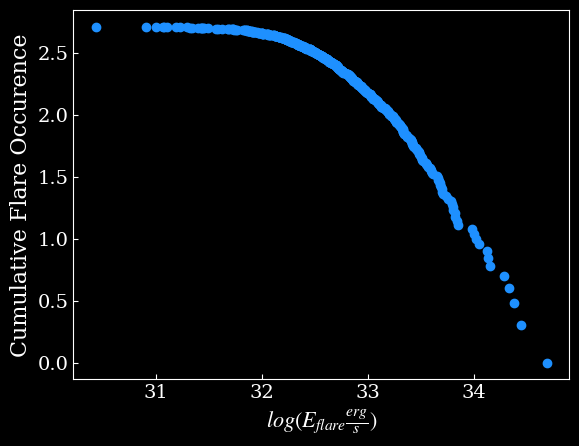

In [606]:
#import given Petrucci flares

known_flares = np.genfromtxt('/Users/jasonreeves/Documents/AST 151 - Graduate Astro Lab/Assignment_5/Petrucci_Table2_v2.txt')

known_flare_energies = known_flares[:, 5]

know_flare_ED_sec = known_flares[:, 3]

#Plot the distribution form Petrucci

plt.hist(np.log10(known_flare_energies), bins = 20, color = 'Green')
plt.title('From Petrucci 2024')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 16)
plt.ylabel(r'Occurrence', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()




#Plot the distribution to get an idea of how it looks

plt.hist(np.log10(flare_energies[flare_energies > 0]), bins = 20, color = 'Green')
#plt.errorbar(flare_tot_bin_centers, flare_tot_hist, yerr = flare_tot_error, color = 'green', capsize =4, linestyle = '')
plt.title('Calculated Here')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 16)
plt.ylabel(r'Occurrence', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()


#We need to find the Cumulative flare count, which is the number
#of the flares of energy E or higher

flare_energies = flare_energies[flare_energies > 0]

#sort the flares from most energetic to least

flare_energies = np.flip(np.sort(flare_energies))


cumulative_flare_count = np.zeros(len(flare_energies))


cumulative_flare_value = np.zeros(len(flare_energies))

for i in range(len(flare_energies)):

    #add up all the counts of index i and above

    cumulative_flare_count[i] = len(np.where(flare_energies >= flare_energies[i])[0])

    cumulative_flare_value[i] = flare_energies[i]




plt.scatter(np.log10(cumulative_flare_value), np.log10(cumulative_flare_count), color = 'dodgerblue')

plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 16)
plt.ylabel(r'Cumulative Flare Occurence', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

Who recovered more flares?

In [608]:
print('Petrucci Found ' + str(len(known_flare_energies) - len(flare_energies)) + ' more flares than I did')

print('')

print('That is ' + str(round(((len(known_flare_energies) - len(flare_energies))/len(flare_energies) * 100), 1)) +
      ' percent more flares than me!')

Petrucci Found 264 more flares than I did

That is 51.4 percent more flares than me!


# Uh Oh

It looks like Petrucci found a few more flares. Is there a problem in my code? I don't think so. I'm missing a bit of data compared to them. Of course I'm missing two TESS sectors from one TIC that's massively corrupted (as stated much earlier at the beginning of the notebook) and does brick my loop if I try to download it. There are also a number of sectors for some objects that are just plain missing for some reason. I estimate that in total a couple dozen sectors are missing, maybe more. There are 4 sectors missing from object 307956653 alone. This goes most of the way in addessing the discrepencies, although our numbers may be off by like 5% or less. That kind of difference makes sense for two different codes. Overall I'm happy with my flare detection code and I think these results reflect quality work.

# Calculate the Number of Missing Sectors

In [611]:
#Scrape how many sectors are in the CSV file from Petrucci
#Documenting what data they used

number_sectors_Petrucci = 0

for i in range(len(flare_stars)):

    sectors_in_tic = len(re.findall("(\d+)", flare_stars['TESS sectors'][i]))

    number_sectors_Petrucci += sectors_in_tic


#Go into my directory and scrape how many files are in the folder containing the
#TESS sectors I downloaded

path = '/Users/jasonreeves/Documents/AST 151 - Graduate Astro Lab/Assignment_5/Petrucci_Light_Curves_Sector_Limited/'

number_sectors_here = len(os.listdir(path))

print('Petrucci uses ' + str(number_sectors_Petrucci - number_sectors_here) + ' more sectors than me')

Petrucci uses 105 more sectors than me


So yeah, the discrepency in flare count is likely entirely owed to missing TESS Sectors

In [613]:
# And now the counts for the classes of the stars

#LOW TEMP


#sort the flares from most energetic to least

flare_energies_low_temp = flare_energies_low_temp[flare_energies_low_temp > 0]


flare_energies_low_temp = np.flip(np.sort(flare_energies_low_temp))


cumulative_flare_count_low_temp = np.zeros(len(flare_energies_low_temp))


cumulative_flare_value_low_temp = np.zeros(len(flare_energies_low_temp))


for i in range(len(flare_energies_low_temp)):

    #add up all the counts of index i and above

    cumulative_flare_count_low_temp[i] = len(np.where(flare_energies_low_temp >= flare_energies_low_temp[i])[0])

    cumulative_flare_value_low_temp[i] = flare_energies_low_temp[i]



#MID TEMP



#sort the flares from most energetic to least

flare_energies_mid_temp = flare_energies_mid_temp[flare_energies_mid_temp > 0]


flare_energies_mid_temp = np.flip(np.sort(flare_energies_mid_temp))


cumulative_flare_count_mid_temp = np.zeros(len(flare_energies_mid_temp))


cumulative_flare_value_mid_temp = np.zeros(len(flare_energies_mid_temp))


for i in range(len(flare_energies_mid_temp)):

    #add up all the counts of index i and above

    cumulative_flare_count_mid_temp[i] = len(np.where(flare_energies_mid_temp >= flare_energies_mid_temp[i])[0])

    cumulative_flare_value_mid_temp[i] = flare_energies_mid_temp[i]


#HIGH TEMP


#sort the flares from most energetic to least

flare_energies_high_temp = flare_energies_high_temp[flare_energies_high_temp > 0]


flare_energies_high_temp = np.flip(np.sort(flare_energies_high_temp))


cumulative_flare_count_high_temp = np.zeros(len(flare_energies_high_temp))


cumulative_flare_value_high_temp = np.zeros(len(flare_energies_high_temp))


for i in range(len(flare_energies_high_temp)):

    #add up all the counts of index i and above

    cumulative_flare_count_high_temp[i] = len(np.where(flare_energies_high_temp >= flare_energies_high_temp[i])[0])

    cumulative_flare_value_high_temp[i] = flare_energies_high_temp[i]

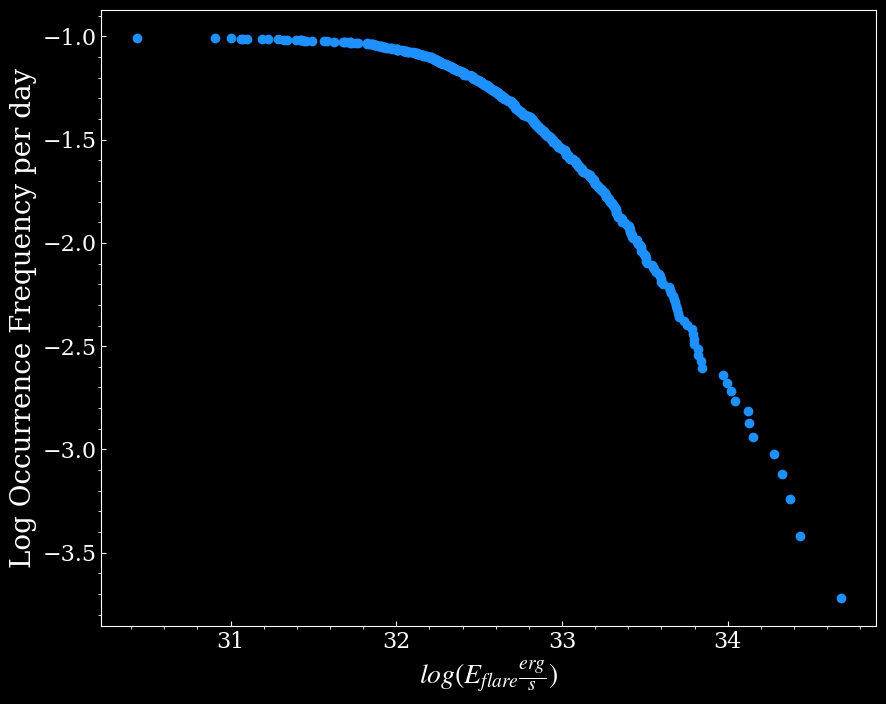

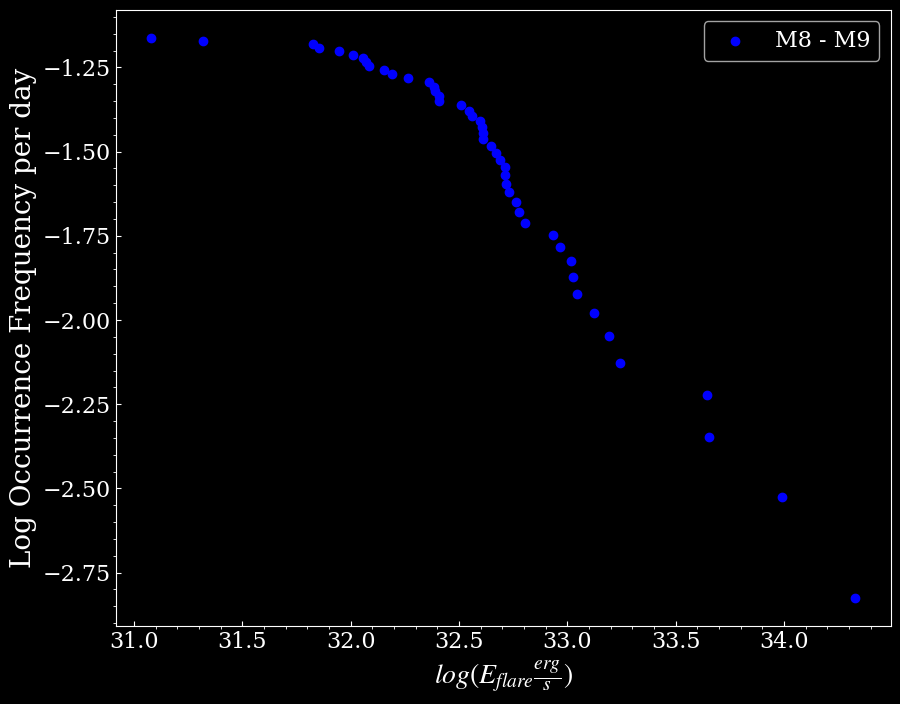

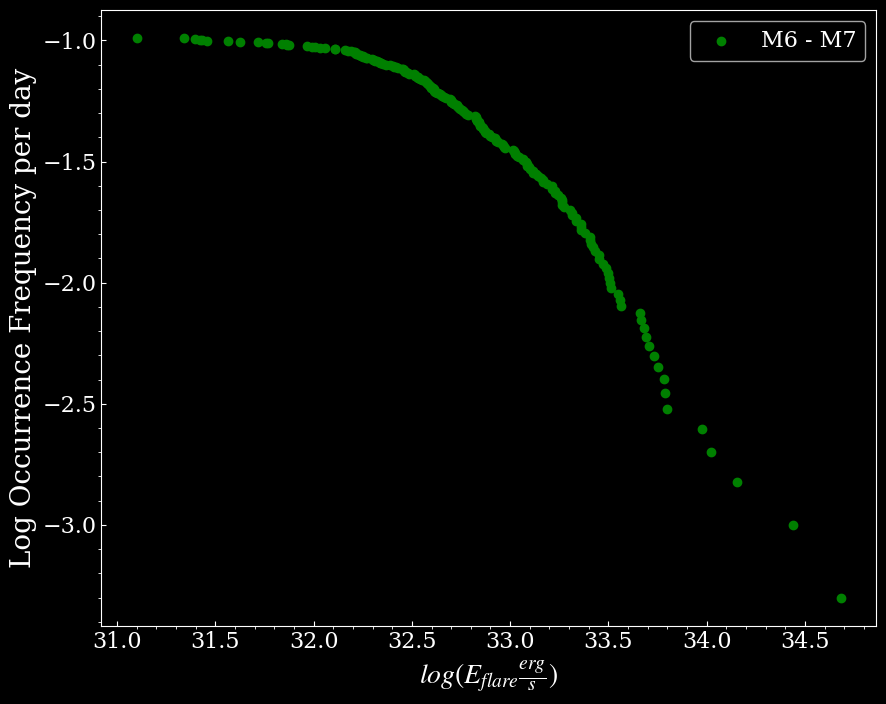

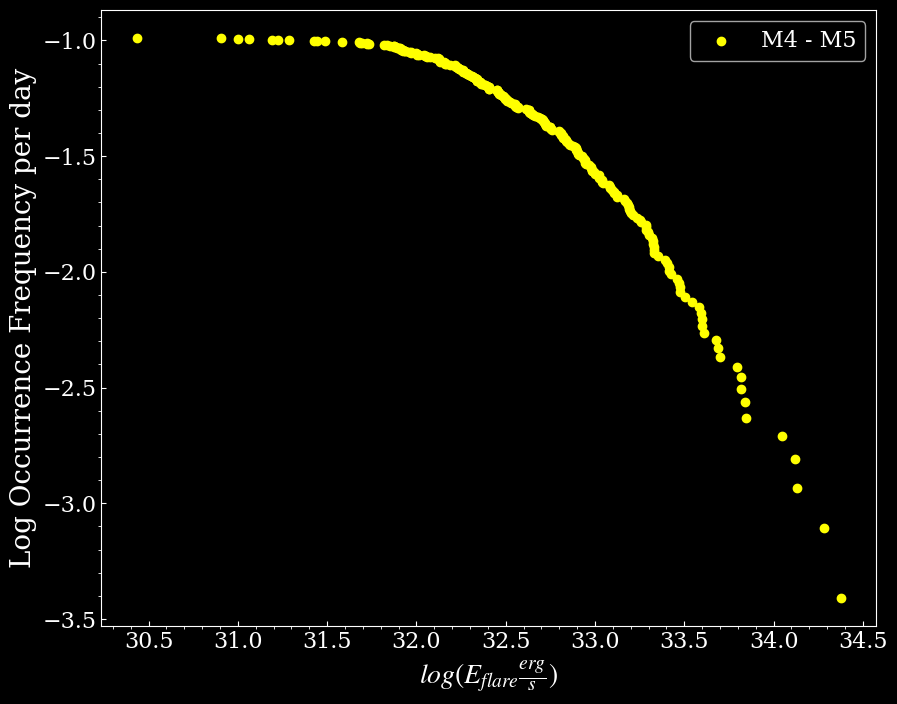

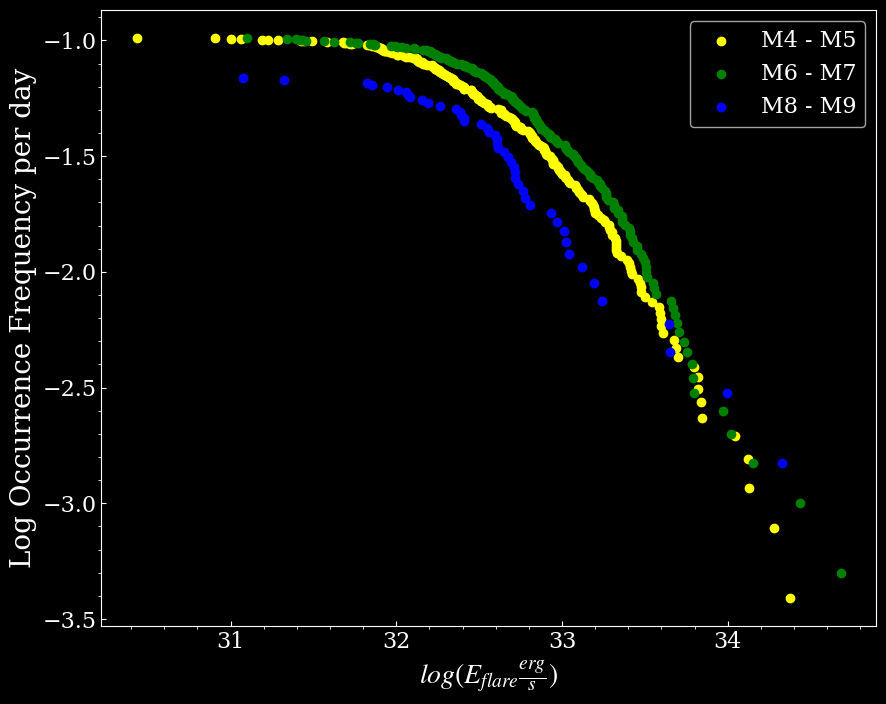

In [614]:
#OK, frequency plots!

flare_energies = flare_energies[flare_energies > 0]

#IT'S SHORT FOR COMULATIVE! GET YOUR MIND OUT OF THE GUTTER!

cum_flare_freqs = cumulative_flare_count / total_time_of_observation

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value), np.log10(cum_flare_freqs), color = 'dodgerblue')
#plt.plot((31.8, 32.8), (-0.7, -2.4), linestyle = '--', color = 'black', label = 'Petrucci Line of Best Fit')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.7, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()



flare_energies_low_temp = flare_energies_low_temp[flare_energies_low_temp > 0]

cum_flare_freqs_low_temp = cumulative_flare_count_low_temp / time_of_observation_low_temp

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_low_temp),
            np.log10(cum_flare_freqs_low_temp), color = 'blue',
            label = 'M8 - M9')
#plt.plot((31.8, 32.8), (-0.7, -2.4), linestyle = '--', color = 'black', label = 'Petrucci Line of Best Fit')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()



flare_energies_mid_temp = flare_energies_mid_temp[flare_energies_mid_temp > 0]

cum_flare_freqs_mid_temp = cumulative_flare_count_mid_temp / time_of_observation_mid_temp

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_mid_temp),
            np.log10(cum_flare_freqs_mid_temp), color = 'green',
            label = 'M6 - M7')
#plt.plot((31.8, 32.8), (-0.7, -2.4), linestyle = '--', color = 'black', label = 'Petrucci Line of Best Fit')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()




flare_energies_high_temp = flare_energies_high_temp[flare_energies_high_temp > 0]


cum_flare_freqs_high_temp = cumulative_flare_count_high_temp / time_of_observation_high_temp

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_high_temp),
            np.log10(cum_flare_freqs_high_temp), color = 'yellow',
            label = 'M4 - M5')
#plt.plot((31.8, 32.8), (-0.7, -2.4), linestyle = '--', color = 'black', label = 'Petrucci Line of Best Fit')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()



plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_high_temp),
            np.log10(cum_flare_freqs_high_temp), color = 'yellow',
            label = 'M4 - M5')
plt.scatter(np.log10(cumulative_flare_value_mid_temp),
            np.log10(cum_flare_freqs_mid_temp), color = 'green',
            label = 'M6 - M7')
plt.scatter(np.log10(cumulative_flare_value_low_temp),
            np.log10(cum_flare_freqs_low_temp), color = 'blue',
            label = 'M8 - M9')
#plt.plot((31.8, 32.8), (-0.7, -2.4), linestyle = '--', color = 'black', label = 'Petrucci Line of Best Fit')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()

Again, compare to Petrucci.

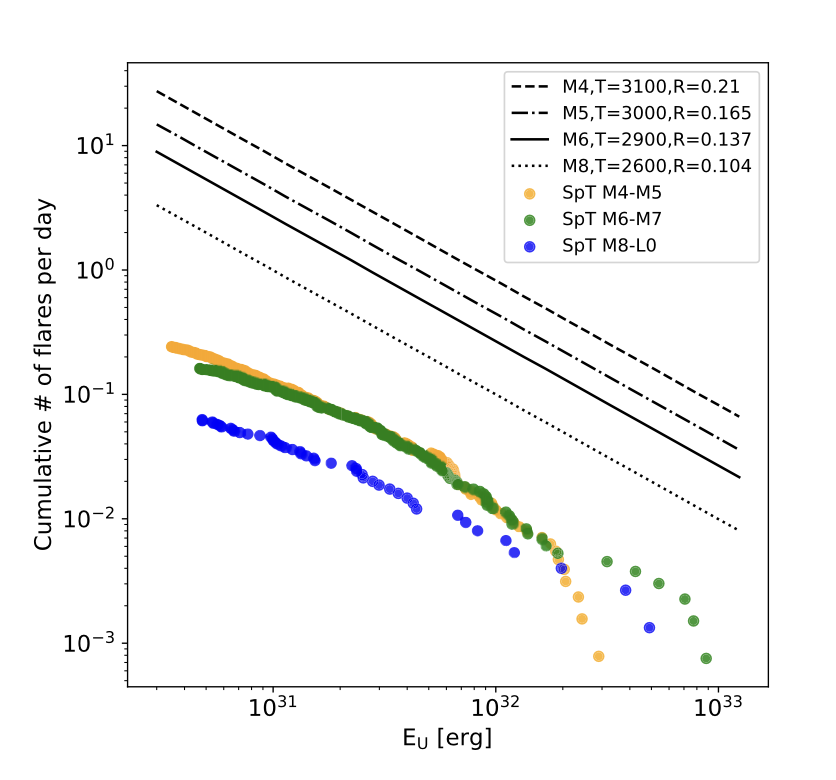

I don't think it looks too bad. I'm pretty happy with this, honestly.

# Fitting a line and estimating uncertainty

Here we'll actually go about estimating the slope of the power law here:


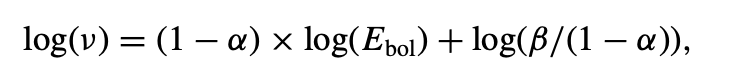


For the fitting procedure we'll np.polyfit to just fit a line and return the slope. The uncertainty will be gained through bootstrapping the points of the CFF and recalculating the slopes.


Can I, AGAIN, complain about Petrucci. From this equation to get a negative slope of the power law we'd need to have a positive value of α, indeed they say whether α is greater than or less than +2 has implications on the heating of the corona from flares. However, when they give their final values of alpha they give NEGATIVE numbers. This leads me to think their value of α is in fact simply the slope of the power law. However they never really explicitly say that! They should've called it something else!!!

In [617]:
# Defining the linear function

def linear_regression(log_E, params):

    m = params[0]

    c = params[1]

    return m * log_E + c


# Flare frequency fit

#initialize the guesses randomly around the correct ones to see if they converge

#only include the stuff with greater log(E) 31.8

power_law_min_log_energy = 31.8

power_law_region = np.where((np.log10(cumulative_flare_value) > power_law_min_log_energy))[0]

x_data_flares = np.log10(cumulative_flare_value[power_law_region])

y_data_flares = np.log10(cum_flare_freqs)[power_law_region]

#Use poly fit

flares_tot_ideal_parameters = np.polyfit(x_data_flares, y_data_flares, 1)

#Keep in mind the alpha is α = 1 - m from the equation above

alpha_flare = 1 - flares_tot_ideal_parameters[0]

###############CHECK THESE VALUES FOR ENERGY BOUNDS LATER!!!!##################
#For the low temp flares
#only include the stuff with greater log(E) 31.8

power_law_min_log_energy_low_temp = 31.8

low_temp_power_law_region = np.where(np.log10(cumulative_flare_value_low_temp) > power_law_min_log_energy_low_temp)[0]

x_data_low_temp = np.log10(cumulative_flare_value_low_temp[low_temp_power_law_region])

y_data_low_temp = np.log10(cum_flare_freqs_low_temp)[low_temp_power_law_region]

#Use poly fit

low_temp_ideal_parameters = np.polyfit(x_data_low_temp, y_data_low_temp, 1)


#Keep in mind the alpha is α = 1 - m from the equation above

alpha_low_temp = 1 - low_temp_ideal_parameters[0]


###############CHECK THESE VALUES FOR ENERGY BOUNDS LATER!!!!##################
#For the mid temp flares
#only include the stuff with greater log(E) 31.8

power_law_min_log_energy_mid_temp = 31.8

mid_temp_power_law_region = np.where(np.log10(cumulative_flare_value_mid_temp) > power_law_min_log_energy_mid_temp)[0]

x_data_mid_temp = np.log10(cumulative_flare_value_mid_temp[mid_temp_power_law_region])

y_data_mid_temp = np.log10(cum_flare_freqs_mid_temp)[mid_temp_power_law_region]

#Use poly fit

mid_temp_ideal_parameters = np.polyfit(x_data_mid_temp, y_data_mid_temp, 1)


#Keep in mind the alpha is α = 1 - m from the equation above

alpha_mid_temp = 1 - mid_temp_ideal_parameters[0]

###############CHECK THESE VALUES FOR ENERGY BOUNDS LATER!!!!##################
#For the high temp flares
#only include the stuff with greater log(E) 31.8

power_law_min_log_energy_high_temp = 31.8

high_temp_power_law_region = np.where(np.log10(cumulative_flare_value_high_temp) > power_law_min_log_energy_mid_temp)[0]

x_data_high_temp = np.log10(cumulative_flare_value_high_temp[high_temp_power_law_region])

y_data_high_temp = np.log10(cum_flare_freqs_high_temp)[high_temp_power_law_region]

#Use poly fit

high_temp_ideal_parameters = np.polyfit(x_data_high_temp, y_data_high_temp, 1)


#Keep in mind the alpha is α = 1 - m from the equation above

alpha_high_temp = 1 - high_temp_ideal_parameters[0]



## Plot the final result for the Petrucci Sample

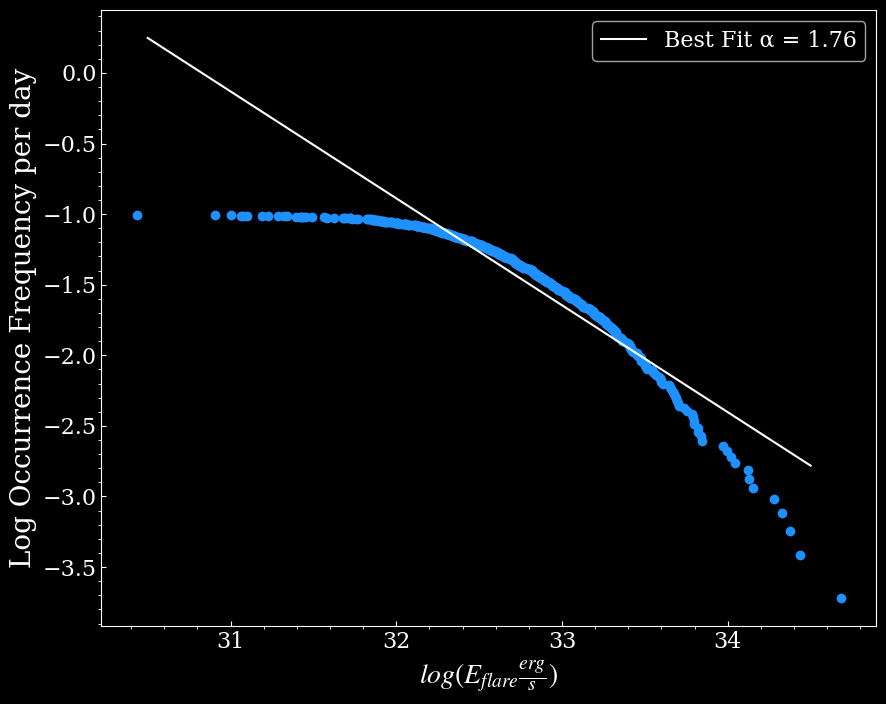

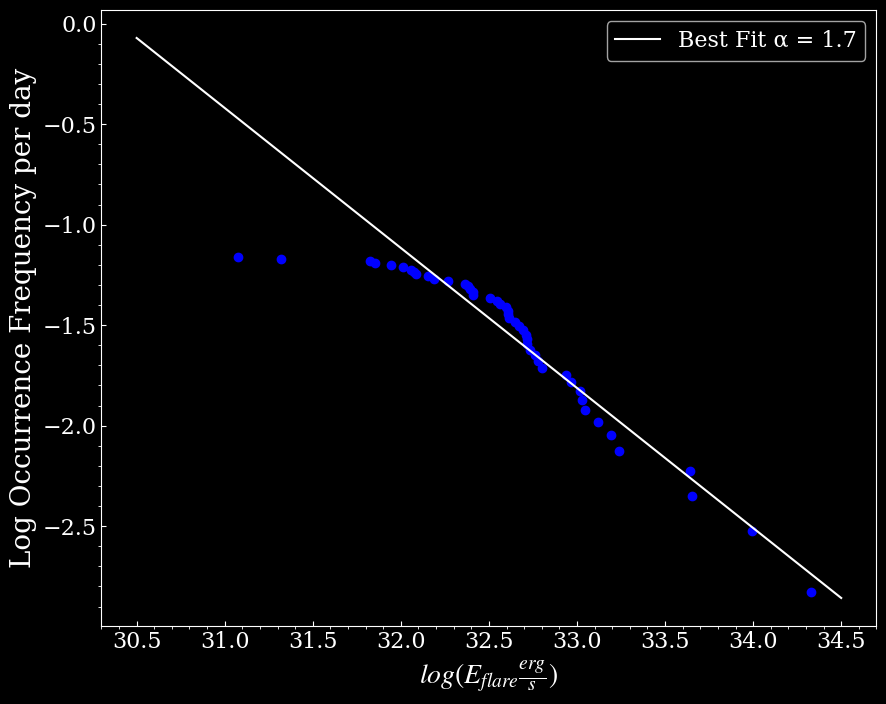

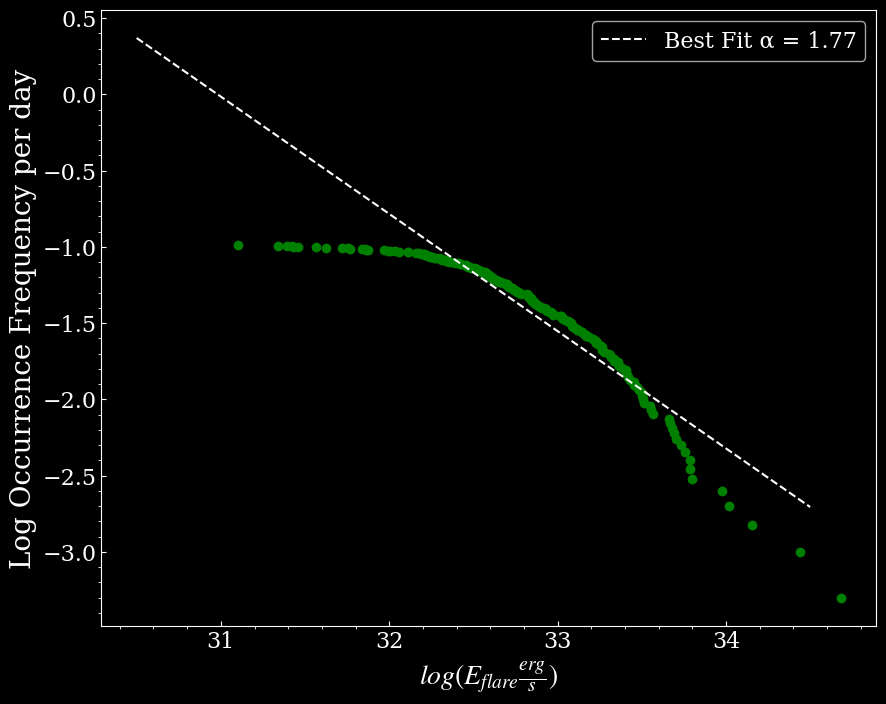

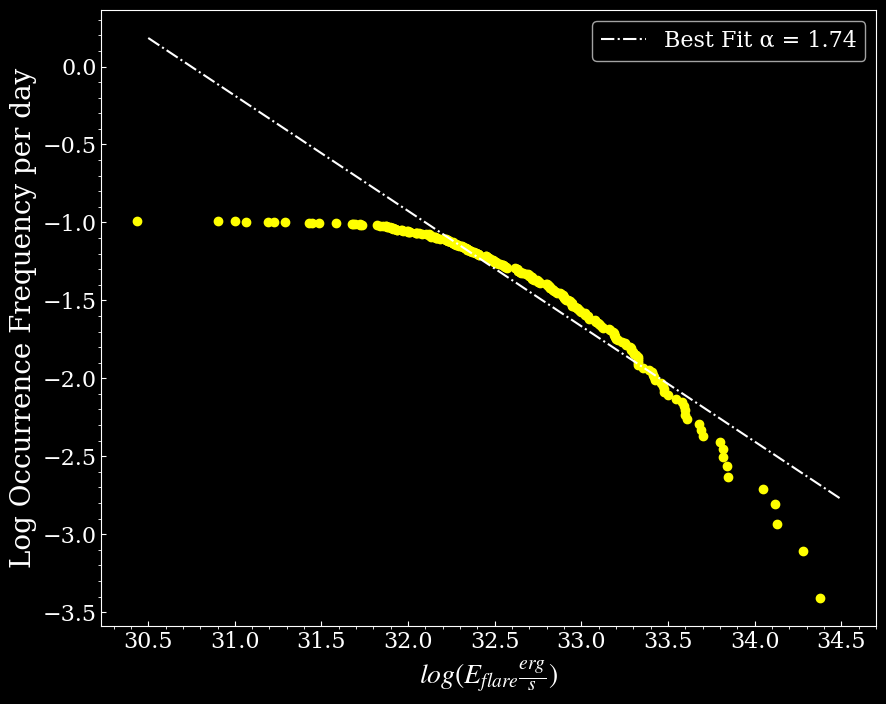

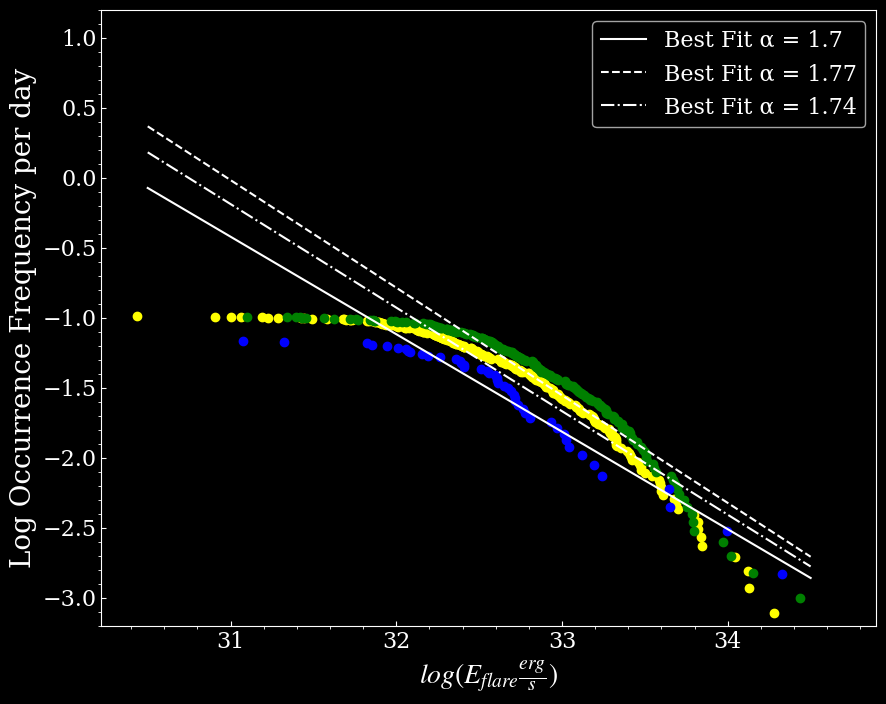

In [619]:
#OK, final plots!

log_E = np.linspace(30.5, 34.5, 100)

# Defining the linear function

def linear_regression(log_E, params):

    m = params[0]

    c = params[1]

    return m * log_E + c

#OK, frequency plots!

#fit all the flares

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value), np.log10(cum_flare_freqs), color = 'dodgerblue')
plt.plot(log_E, linear_regression(log_E, flares_tot_ideal_parameters), linestyle = '-', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_flare, 2)))
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.7, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()


######### LOW TEMP ###############

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_low_temp),
            np.log10(cum_flare_freqs_low_temp), color = 'blue')
plt.plot(log_E, linear_regression(log_E, low_temp_ideal_parameters), linestyle = '-', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_low_temp, 2)))
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()



######### MID TEMP ###############

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_mid_temp),
            np.log10(cum_flare_freqs_mid_temp), color = 'green')
plt.plot(log_E, linear_regression(log_E, mid_temp_ideal_parameters), linestyle = '--', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_mid_temp, 2)))
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()


######### HIGH TEMP ###############

flare_energies_high_temp = flare_energies_high_temp[flare_energies_high_temp > 0]


log_flare_freqs_high_temp = cumulative_flare_count_high_temp / time_of_observation_high_temp

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_high_temp),
            np.log10(log_flare_freqs_high_temp), color = 'yellow')
plt.plot(log_E, linear_regression(log_E, high_temp_ideal_parameters), linestyle = '-.', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_high_temp, 2)))
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()


######### OVERPLOT ###############


plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_high_temp),
            np.log10(cum_flare_freqs_high_temp), color = 'yellow')
plt.scatter(np.log10(cumulative_flare_value_mid_temp),
            np.log10(cum_flare_freqs_mid_temp), color = 'green')
plt.scatter(np.log10(cumulative_flare_value_low_temp),
            np.log10(cum_flare_freqs_low_temp), color = 'blue')
plt.plot(log_E, linear_regression(log_E, low_temp_ideal_parameters), linestyle = '-', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_low_temp, 2)))
plt.plot(log_E, linear_regression(log_E, mid_temp_ideal_parameters), linestyle = '--', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_mid_temp, 2)))
plt.plot(log_E, linear_regression(log_E, high_temp_ideal_parameters), linestyle = '-.', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_high_temp, 2)))
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.2)
plt.ylim(-3.2, 1.2)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()

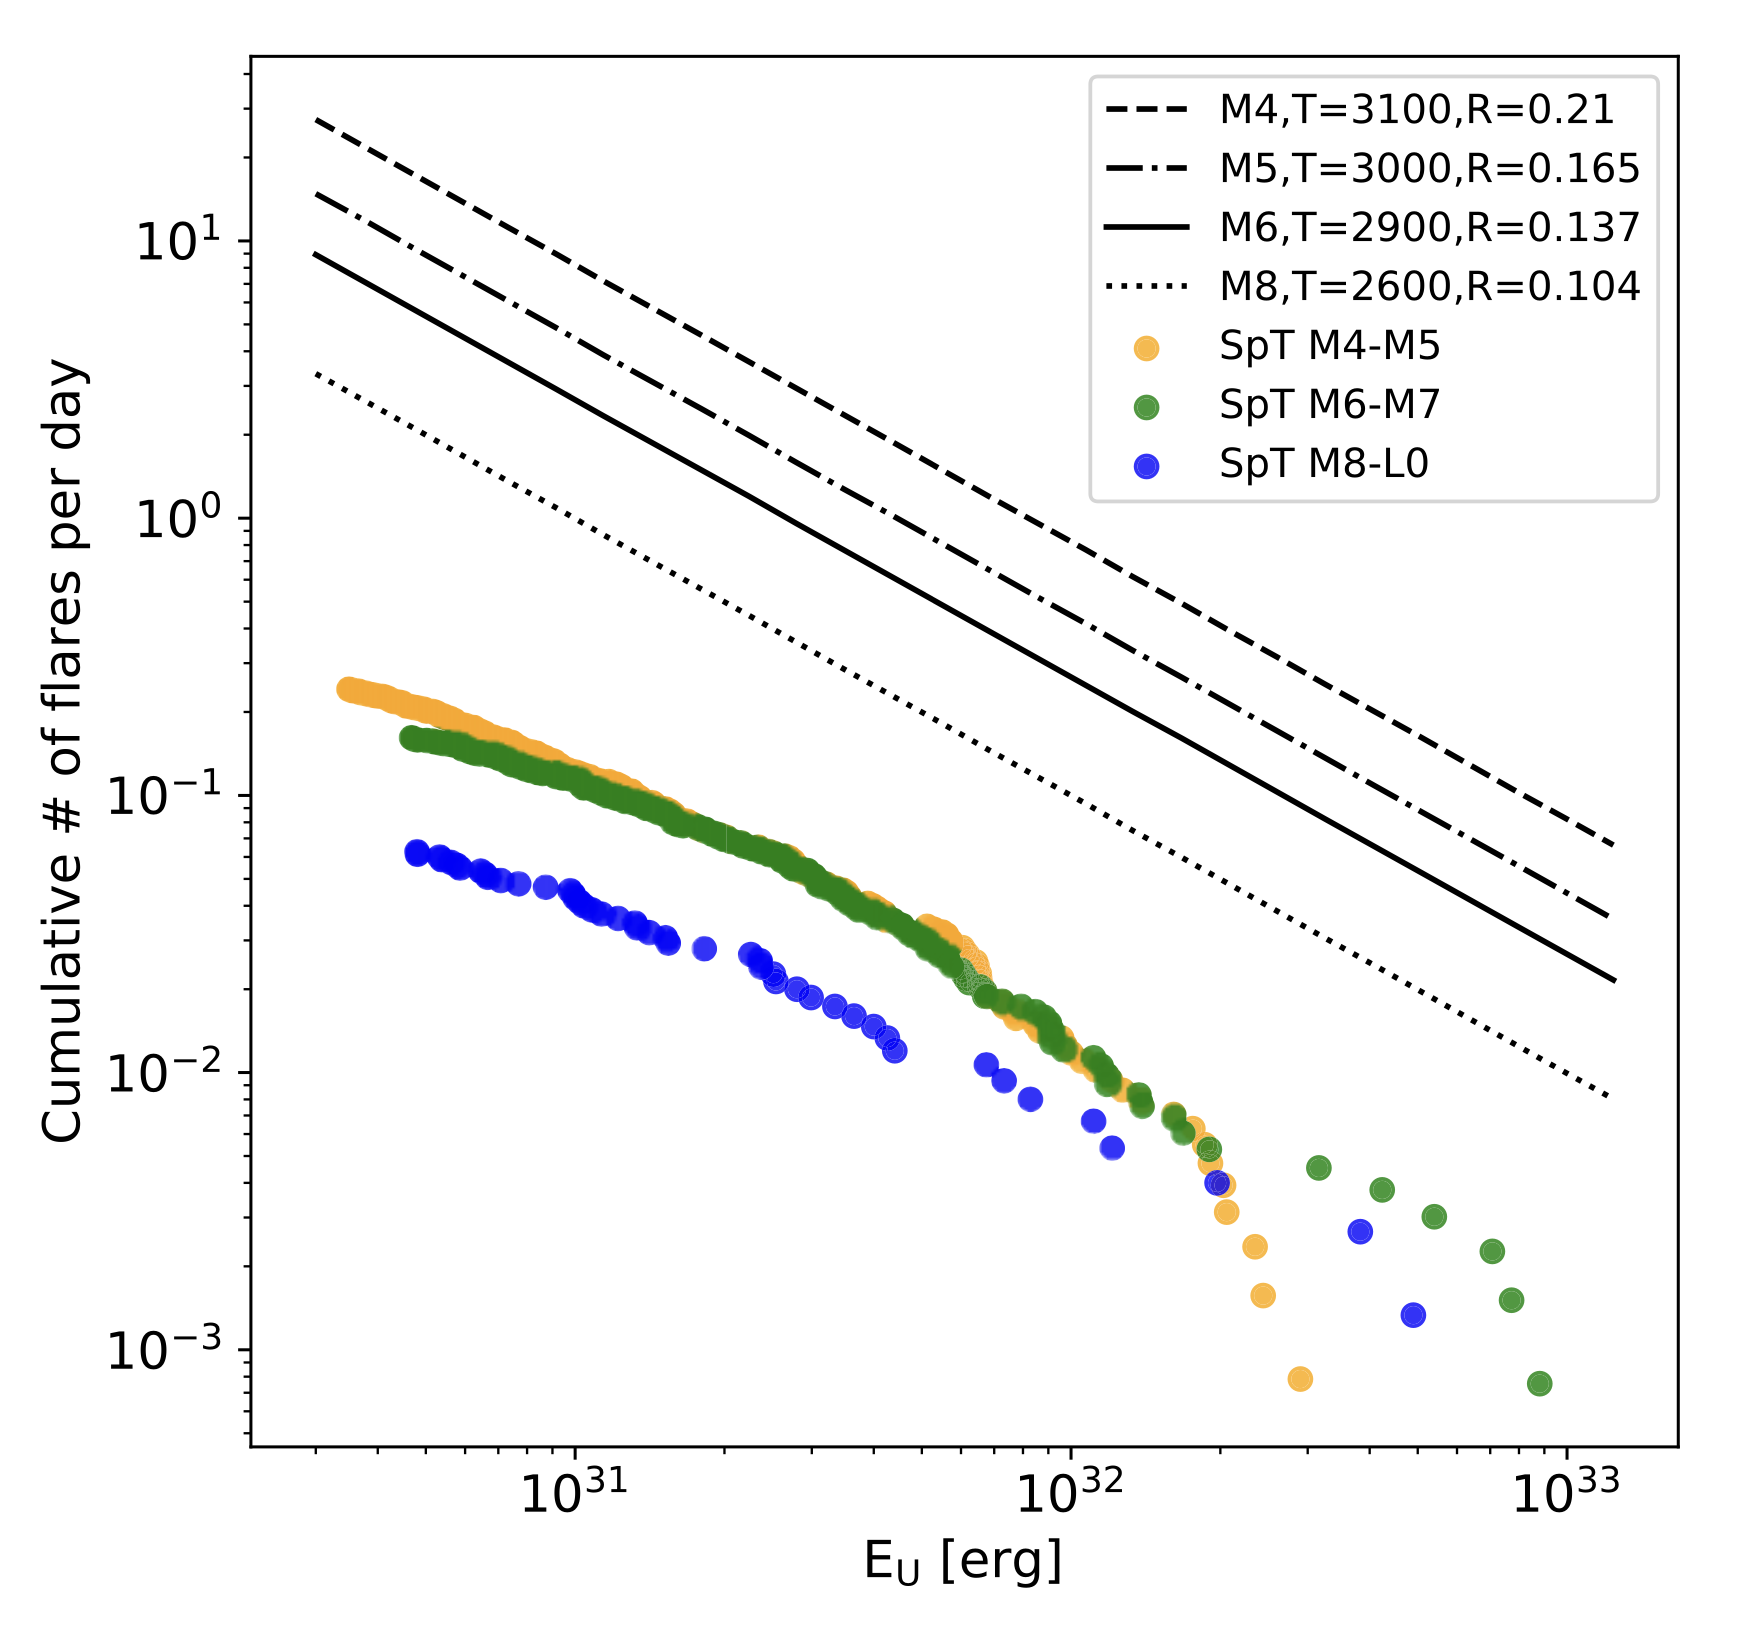

# Bootstrapping Uncertainty

To estimate uncertainty we'll bootstrap the frequency points. That just means randomly resampling the points and doing the linear regression of those points and finding the standard deviation of the calculated means.

One small detail is that I fear the slope depends greatly on where the line is drawn as to where the power law is said to apply so I will also randomly select the lower bound and redo the analysis.

Now we'll be bootsrapping the slopes but this IS equivalent to bootstrapping α ditectly which is the slope minus 1. The slope and the value of α is directly proportional and not affected by any other variables so truly finding $\sigma_m$ will be the same as $\sigma_{\alpha}$

In [622]:
#The first value is the x value, the flare energy in linear scale
#The second value is the y value, the Flare Frequency
#The third value is point where I called the power law valid
#N_samples is the number of bootstrapped samples we'll use

def bootstrapping_CFF_sigma(flare_count, flare_frequency, power_law_cutoff, N_samples):

    #initialize array to hold the slopes from each sample

    bootstrapped_slopes = np.array([])

    for i in range(N_samples):

        #select power law cut of from random uniform distribution
        #centered on my value with width of dx which represents my doubt
        #that my value is correct

        dx = 0.25
        
        rand_power_law_cutoff = np.random.uniform(power_law_cutoff - dx, power_law_cutoff + dx)

        #Make cut in the data

        power_law_region = np.where(np.log10(flare_count) > rand_power_law_cutoff)[0]

        x_data = flare_count[power_law_region]

        y_data = flare_frequency[power_law_region]

        #Bootstrap from these indices

        bootstrapped_index = np.random.choice(len(x_data), len(x_data), replace = True)

        #Make sure data is in log space
    
        bootstrapped_x_data = np.log10(x_data[bootstrapped_index])
    
        bootstrapped_y_data = np.log10(y_data[bootstrapped_index])   
    
        #fit linear regression
    
        ideal_slope = np.polyfit(bootstrapped_x_data, bootstrapped_y_data, 1)[0]

        #add to list

        bootstrapped_slopes = np.append(bootstrapped_slopes, ideal_slope)

    #take standard deviation of the slopes

    slope_sigma = np.std(bootstrapped_slopes)

    return slope_sigma


# Bootstrapping the full sample

N_samples = 100



flare_freqs_sigma = bootstrapping_CFF_sigma(cumulative_flare_value, cum_flare_freqs,
                                            power_law_min_log_energy, N_samples)


#bootstrapping low temp sample

flare_freqs_low_temp_sigma = bootstrapping_CFF_sigma(cumulative_flare_value_low_temp, cum_flare_freqs_low_temp,
                                            power_law_min_log_energy_low_temp, N_samples)


#bootstrapping mid temp sample

flare_freqs_mid_temp_sigma = bootstrapping_CFF_sigma(cumulative_flare_value_mid_temp, cum_flare_freqs_mid_temp,
                                            power_law_min_log_energy_mid_temp, N_samples)

#bootstrapping high temp sample

flare_freqs_high_temp_sigma = bootstrapping_CFF_sigma(cumulative_flare_value_high_temp, cum_flare_freqs_high_temp,
                                            power_law_min_log_energy_high_temp, N_samples)

## Print Final Outputs

In [624]:
print('The best fit slope of the power law for all the flares is ' + str(round(alpha_flare, 2))
    + ' ± ' + str(round(flare_freqs_sigma, 2)))

print('')

print('The best fit slope of the power law for the low temp stuff is ' + str(round(alpha_low_temp, 2))
    + ' ± ' + str(round(flare_freqs_low_temp_sigma, 2)))

print('')

print('The best fit slope of the power law for the low temp stuff is ' + str(round(alpha_mid_temp, 2))
    + ' ± ' + str(round(flare_freqs_mid_temp_sigma, 2)))

print('')

print('The best fit slope of the power law for the low temp stuff is ' + str(round(alpha_high_temp, 2))
    + ' ± ' + str(round(flare_freqs_high_temp_sigma, 2)))

The best fit slope of the power law for all the flares is 1.76 ± 0.04

The best fit slope of the power law for the low temp stuff is 1.7 ± 0.04

The best fit slope of the power law for the low temp stuff is 1.77 ± 0.04

The best fit slope of the power law for the low temp stuff is 1.74 ± 0.04


# A New Sample Arrives

Below I unpack 241 objects from the TICv8.2 survey. The critria of selection only consists of three parts:

1) All must be classified as dwarves
2) All must have tabulated luminosities between 0 and 0.5 solar luminosity
3) All must have some uncertainty in luminosity
4) All have detected flares

I hope you all know I did the flare selection by myself. I started with a larger sample of about 1000 objects and narrowed down which ones have flares acros all their TESS sectors. I fit tens of thousands of lightcurves on my MacBook and most of them had NOTHING.

I also download the temperatures of these objects as a proxy for spectral class. Here's some table I ripped from Wikipedia

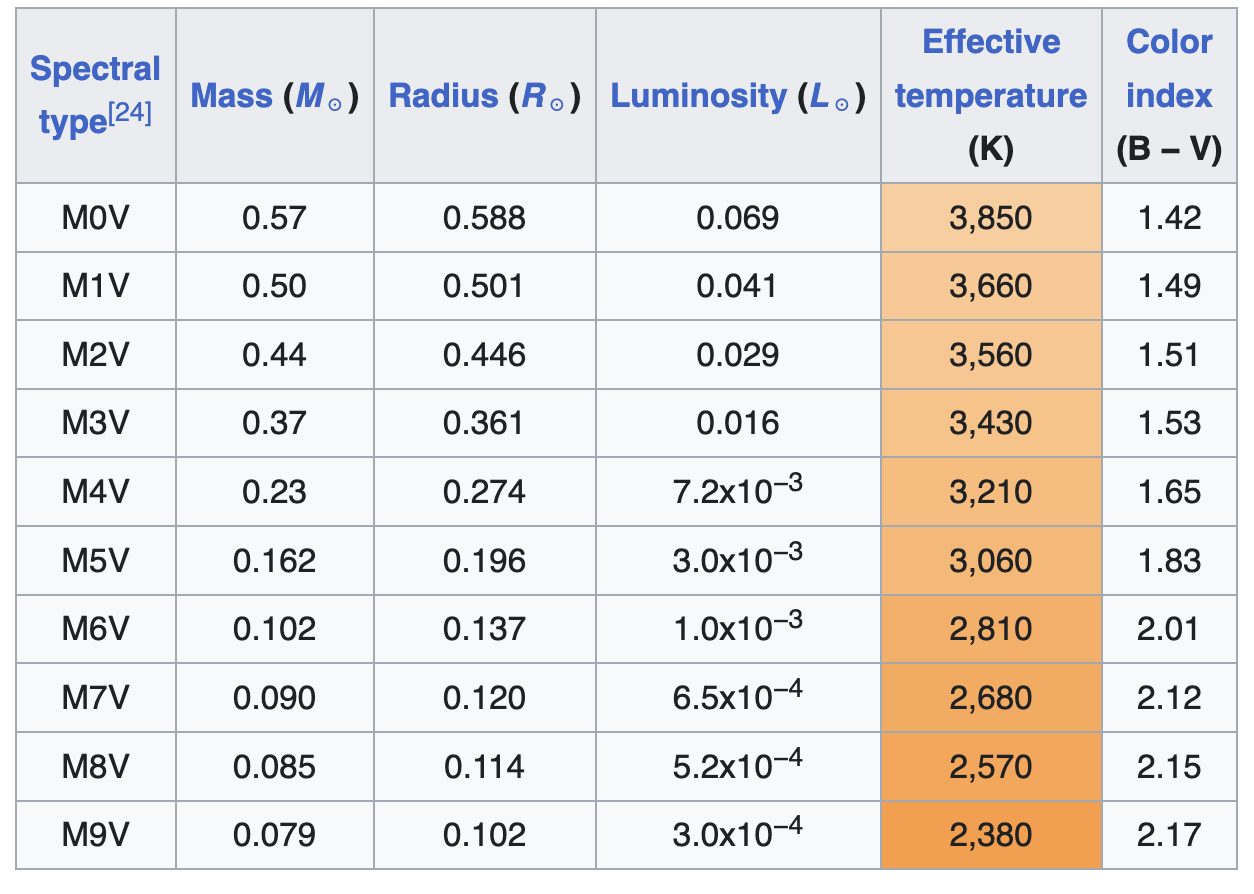

Looking at the demographics, we see my sample contains many more hot objects. This is pretty exciting! It means there's a real difference between the samples used in the Petrucci paper and here giving us a real sense of comparison between different stellar populations!

Now let's talk systematics. Because my sample contains more luminous objects, that will have an effect on the types of flares that we can detect. Because the stars are more luminous the peaks in the light curves will be smaller relative to the quiescent luminosity of the star. We'll only be able to detect more energetic flares if we still use a confidence of $\sigma^2 = 3.85$. This leaves us with two options: change the threshold of detection to something smaller to catch all the smaller flares or keep the current threshold and be more complete on the more energetic flares. I've elected to go with the latter and keep the threshold the same. This is just for empirical consistency in making sure the methodologies are identicle between the two analyses, although in order to be statistically complete for the higher energy stuff it's a good thing I have such a large sample. This shouldn't affect the qualitative analysis of the flares because they all should still follow the power law we expect. With a large enough sample we should still catch enough of these high energy flares to make a statistically significant analysis on the power law of frequency distribution.

So, in short, when the distribution of flare energies is different with the mean of the distribution here being an order of magnitude higher we shouldn't worry.

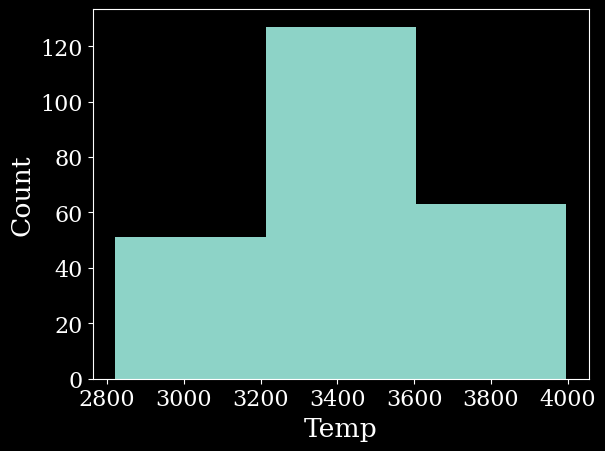

In [626]:
#Import information on TIC number, luminosity (in erg/s), and temperature

TIC_Objects = Table.read('/Users/jasonreeves/Documents/AST 151 - Graduate Astro Lab/Assignment_5/TESS_Object_TICs.csv',
                         format = 'ascii.csv')


#Plot distribution of surface temps in the three bins we'll be using here

plt.hist(TIC_Objects['Teff'], bins = 3)
plt.xlabel('Temp')
plt.ylabel('Count')
plt.show()

# Download Light Curve Data

It's gonna take a while, it IS 241 stars!

There was once where it said it couldn't download the data becuase it's corrupted. It still managed to download over 1,300 lightcurves so I didn't freak out too much but be warned you might need to clip out some individual curves that are corrupted

In [ ]:
#first dimension is the TESS object

#second dimension is the time, flux, quality



for i in range(len(TIC_Objects)):

    #identify the star in question
    #Make sure all the tics are given as integers
    star = int(TIC_Objects['TIC'][i])

    tpfs = search_targetpixelfile('TIC ' + str(star)).download_all()

    if type(tpfs) != type(None):

        #iterate through the tpfs

        for j in range(len(tpfs)):

            #get the lightcurve

            light_curve = tpfs[j].to_lightcurve()

            time = light_curve.time.value

            flux = light_curve.flux.value

            quality = light_curve.quality.value

            light_curve = np.array([time, flux, quality])

            #find the flares

            flare_EDs = flare_finder(light_curve)[2]

            #if this lightcurve has flares

            if len(flare_EDs) > 0:

                #add this light curve to the file

                M_dwarf_light_curv = np.asarray([time,flux,quality])

                path = '/Users/jasonreeves/Documents/AST 151 - Graduate Astro Lab/Assignment_5/M_Class_Dwarf_Light_Curves/'
                
                file_path = (path + 'M_Class_Dwarf_' + str(star) + '_' + str(j) + '.csv')

                np.savetxt(file_path, M_dwarf_light_curv, delimiter=',')

# Find the flares

For the record the folder containing the light curve only of the sources that have flares is 1.7 GB

In [627]:
warnings.filterwarnings("ignore")
#great, now we just need to do it for all our stars and sort their spectral types

path = '/Users/jasonreeves/Documents/AST 151 - Graduate Astro Lab/Assignment_5/M_Class_Dwarf_Light_Curves/'

ED_s = np.array([[],[],[],[]])

flare_energies_high_temp = np.array([])

flare_energies_mid_temp = np.array([])

flare_energies_low_temp = np.array([])

#and an array with all of them, for fun

flare_energies = np.array([])

#running tally of observation time in systems with observed flares

total_time_of_observation = 0

time_of_observation_high_temp = 0

time_of_observation_mid_temp = 0

time_of_observation_low_temp = 0

    
for name in os.listdir(path):

    #sometimes bunk files get caught up in the directory so we're gonna check to see
    #if the file starts with 'M'

    if name[0] == 'M':
        
        #import light curve from folder
        light_curve = np.genfromtxt(path + name, delimiter = ',')

        #unpack
    
        #find which index this is in the Petrucci data for Luminosity and Spectral Class
        #Find TIC number

        TIC_number = re.findall("(\d+)", name)[0]
        
        M_Dwarf_index = TIC_Objects['TIC'] == int(TIC_number)
    
        #Find Luminosity
    
        Lum = TIC_Objects['Lum'][M_Dwarf_index] #Quiescent Lum in erg/s
    
        #And Effective Temperature
    
        T_eff = TIC_Objects['Teff'][M_Dwarf_index]
    
        #find the flares
    
        flare_EDs = flare_finder(light_curve)[2]
                
        ED_s = np.append(ED_s, flare_finder(light_curve), axis = 1)
    
        if len(flare_EDs) > 0:
    
            #find the energies
    
            flare_Es = flare_energy_calc(L_bol, flare_EDs)
    
            #add to appropriate bin based on spectral class
    
            #low temp stuff

            if T_eff < 3200: 

                flare_energies_low_temp = np.append(flare_energies_low_temp, flare_Es)

                time_of_observation_low_temp = time_of_observation_low_temp + time_of_obs(light_curve)

            #mid temp studd

            elif (T_eff >= 3200) & (T_eff < 3600):

                flare_energies_mid_temp = np.append(flare_energies_mid_temp, flare_Es)

                time_of_observation_mid_temp = time_of_observation_mid_temp + time_of_obs(light_curve)

            #high temp stuff

            elif T_eff >= 3600:

                flare_energies_high_temp = np.append(flare_energies_high_temp, flare_Es)

                time_of_observation_high_temp = time_of_observation_high_temp + time_of_obs(light_curve)

            #unknown stuff

            else:

                print('I dont know what you want me to do, man')
    
                #everything
                
            flare_energies = np.append(flare_energies, flare_Es)
    
            #add to tally of total observation time
                    
            total_time_of_observation = total_time_of_observation + time_of_obs(light_curve)


ED_s = np.concatenate((ED_s, np.array([flare_energies])), axis = 0)

flare_energies = ED_s[4]

# Version if you WANT to download everything

Will take HOURS!

In [ ]:
warnings.filterwarnings("ignore")
#great, now we just need to do it for all our stars and sort their spectral types


#initialize arrays

ED_s = np.array([[],[],[],[]])

flare_energies_high_temp = np.array([])

flare_energies_mid_temp = np.array([])

flare_energies_low_temp = np.array([])

#and an array with all of them, for fun

flare_energies = np.array([])

#running tally of observation time in systems with observed flares

total_time_of_observation = 0

time_of_observation_high_temp = 0

time_of_observation_mid_temp = 0

time_of_observation_low_temp = 0
    
for i in range(len(TIC_Objects)):

    #identify the star in question
    star = TIC_Objects['TIC'][i]

    print(i)

    tpfs = search_targetpixelfile('TIC ' + str(star)).download_all()
    #if they're none type I would like them to pass through
    #otherwise the loop gets messed up and corrupts other files
    #so I'll initialize this with True
    flares_in_this_TIC = True

    if type(tpfs) != type(None):

        #re-initialize it with false so we
        #remove objects that don't have flares

        flares_in_this_TIC = False

        for j in range(len(tpfs)):

            light_curve = tpfs[j].to_lightcurve()

            #find the flares

            flare_EDs = flare_finder(light_curve)[2]
            
            ED_s = np.append(ED_s, flare_finder(light_curve), axis = 1)

            if len(flare_EDs) > 0:

                flares_in_this_TIC = True

                #find the energies

                L_bol = TIC_Objects['Lum'][i] #quiescent lum of star in erg/s

                flare_Es = flare_energy_calc(L_bol, flare_EDs)

                #add to appropriate bin based on spectral class

                #returns  spec class as string
                #first indexed value of these strings are the leading number of class

                T_eff = TIC_Objects['Teff'][i]

                #low temp stuff

                if T_eff < 3200: 

                    flare_energies_low_temp = np.append(flare_energies_low_temp, flare_Es)

                    time_of_observation_low_temp = time_of_observation_low_temp + time_of_obs(light_curve)

            #mid temp studd

                elif (T_eff >= 3200) & (T_eff < 3600):

                    flare_energies_mid_temp = np.append(flare_energies_mid_temp, flare_Es)

                    time_of_observation_mid_temp = time_of_observation_mid_temp + time_of_obs(light_curve)

            #high temp stuff

                elif T_eff >= 3600:

                    flare_energies_high_temp = np.append(flare_energies_high_temp, flare_Es)

                    time_of_observation_high_temp = time_of_observation_high_temp + time_of_obs(light_curve)

            #unknown stuff

                else:

                    print('I dont know what you want me to do, man')

            #everything
            
                flare_energies = np.append(flare_energies, flare_Es)

            #add to tally of total observation time
                
                total_time_of_observation = total_time_of_observation + time_of_obs(light_curve)


ED_s = np.concatenate((ED_s, np.array([flare_energies])), axis = 0)


flare_energies = ED_s[4]
    

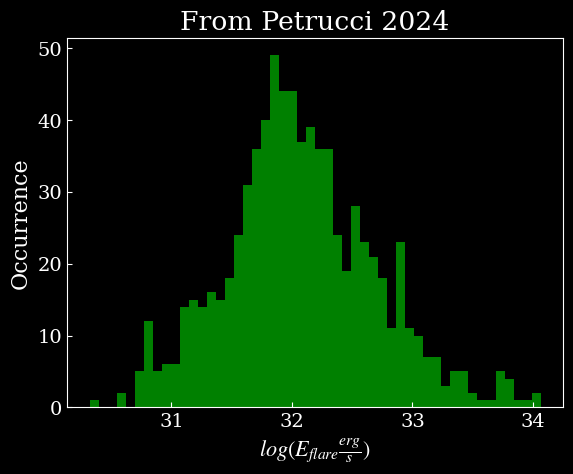

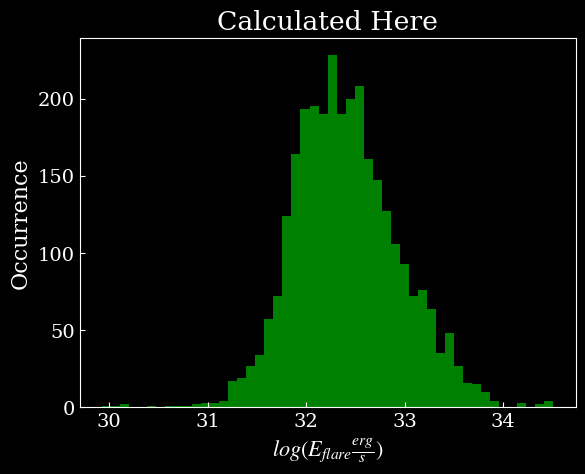

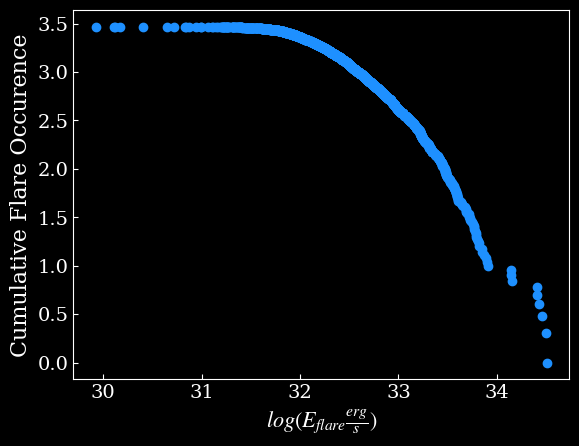

In [628]:
#Plot the distribution form Petrucci

plt.hist(np.log10(known_flare_energies), bins = 50, color = 'Green')
plt.title('From Petrucci 2024')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 16)
plt.ylabel(r'Occurrence', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()




#Plot the distribution to get an idea of how it looks

plt.hist(np.log10(flare_energies[flare_energies > 0]), bins = 50, color = 'Green')
plt.title('Calculated Here')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 16)
plt.ylabel(r'Occurrence', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()




#We need to find the Cumulative flare count, which is the number
#of the flares of energy E or higher

flare_energies = flare_energies[flare_energies > 0]

#sort the flares from most energetic to least

flare_energies = np.flip(np.sort(flare_energies))


cumulative_flare_count = np.zeros(len(flare_energies))


cumulative_flare_value = np.zeros(len(flare_energies))

for i in range(len(flare_energies)):

    #add up all the counts of index i and above

    cumulative_flare_count[i] = len(np.where(flare_energies >= flare_energies[i])[0])

    cumulative_flare_value[i] = flare_energies[i]



plt.scatter(np.log10(cumulative_flare_value), np.log10(cumulative_flare_count), color = 'dodgerblue')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 16)
plt.ylabel(r'Cumulative Flare Occurence', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

In [629]:
# And now the counts for the classes of the stars

#LOW TEMP


#sort the flares from most energetic to least

flare_energies_low_temp = flare_energies_low_temp[flare_energies_low_temp > 0]


flare_energies_low_temp = np.flip(np.sort(flare_energies_low_temp))


cumulative_flare_count_low_temp = np.zeros(len(flare_energies_low_temp))


cumulative_flare_value_low_temp = np.zeros(len(flare_energies_low_temp))


for i in range(len(flare_energies_low_temp)):

    #add up all the counts of index i and above

    cumulative_flare_count_low_temp[i] = len(np.where(flare_energies_low_temp >= flare_energies_low_temp[i])[0])

    cumulative_flare_value_low_temp[i] = flare_energies_low_temp[i]



#MID TEMP



#sort the flares from most energetic to least

flare_energies_mid_temp = flare_energies_mid_temp[flare_energies_mid_temp > 0]


flare_energies_mid_temp = np.flip(np.sort(flare_energies_mid_temp))


cumulative_flare_count_mid_temp = np.zeros(len(flare_energies_mid_temp))


cumulative_flare_value_mid_temp = np.zeros(len(flare_energies_mid_temp))


for i in range(len(flare_energies_mid_temp)):

    #add up all the counts of index i and above

    cumulative_flare_count_mid_temp[i] = len(np.where(flare_energies_mid_temp >= flare_energies_mid_temp[i])[0])

    cumulative_flare_value_mid_temp[i] = flare_energies_mid_temp[i]


#HIGH TEMP


#sort the flares from most energetic to least

flare_energies_high_temp = flare_energies_high_temp[flare_energies_high_temp > 0]


flare_energies_high_temp = np.flip(np.sort(flare_energies_high_temp))


cumulative_flare_count_high_temp = np.zeros(len(flare_energies_high_temp))


cumulative_flare_value_high_temp = np.zeros(len(flare_energies_high_temp))


for i in range(len(flare_energies_high_temp)):

    #add up all the counts of index i and above

    cumulative_flare_count_high_temp[i] = len(np.where(flare_energies_high_temp >= flare_energies_high_temp[i])[0])

    cumulative_flare_value_high_temp[i] = flare_energies_high_temp[i]

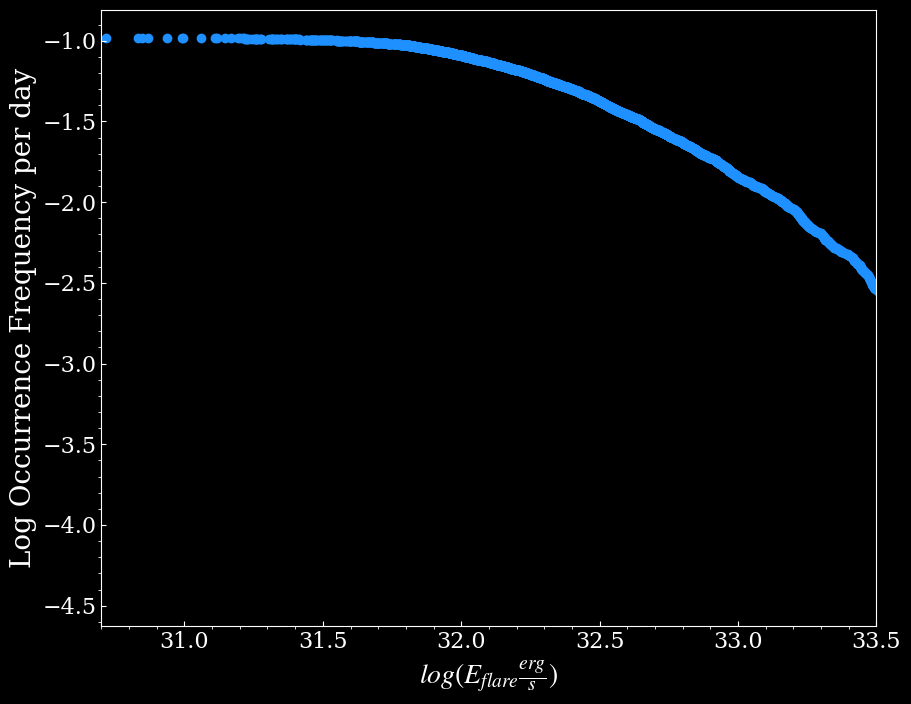

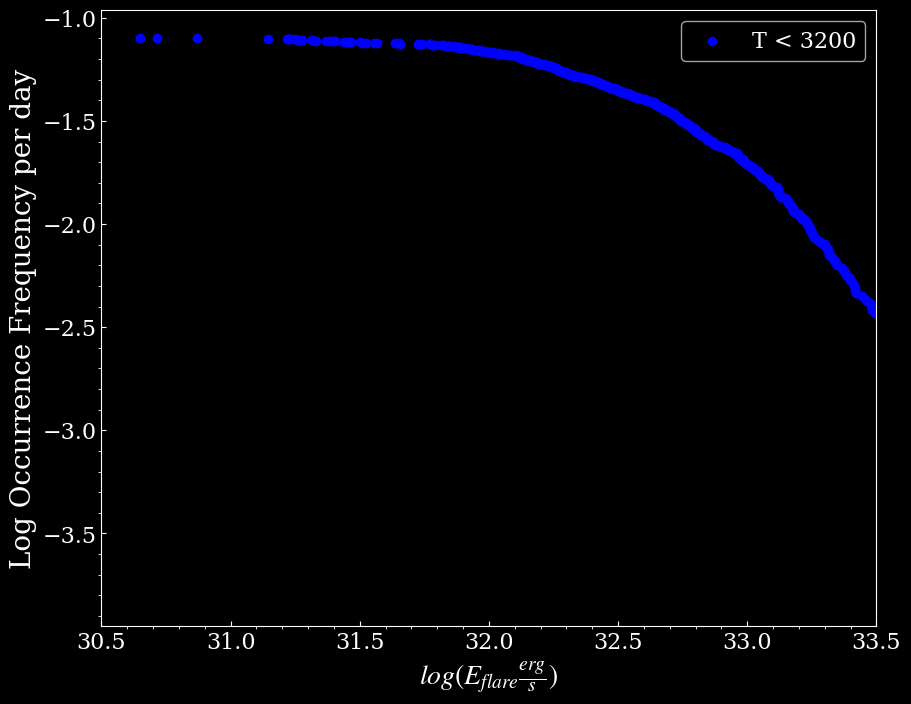

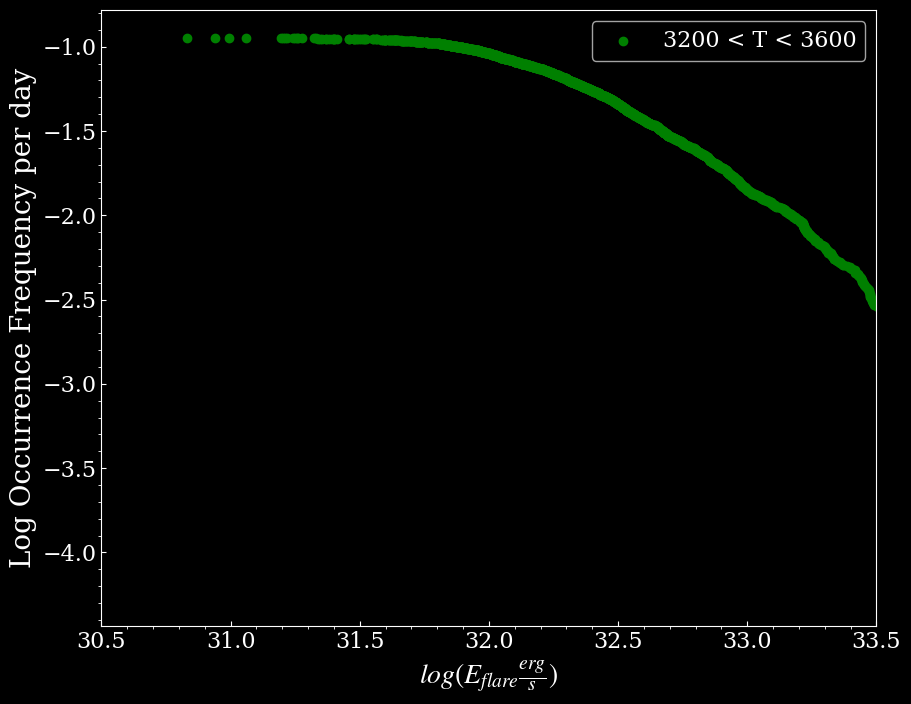

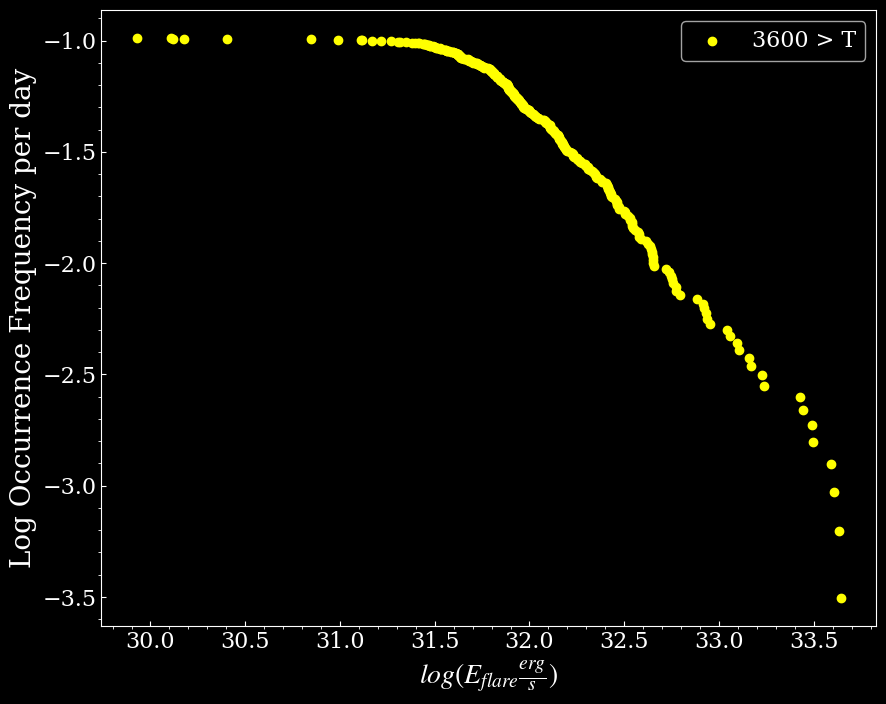

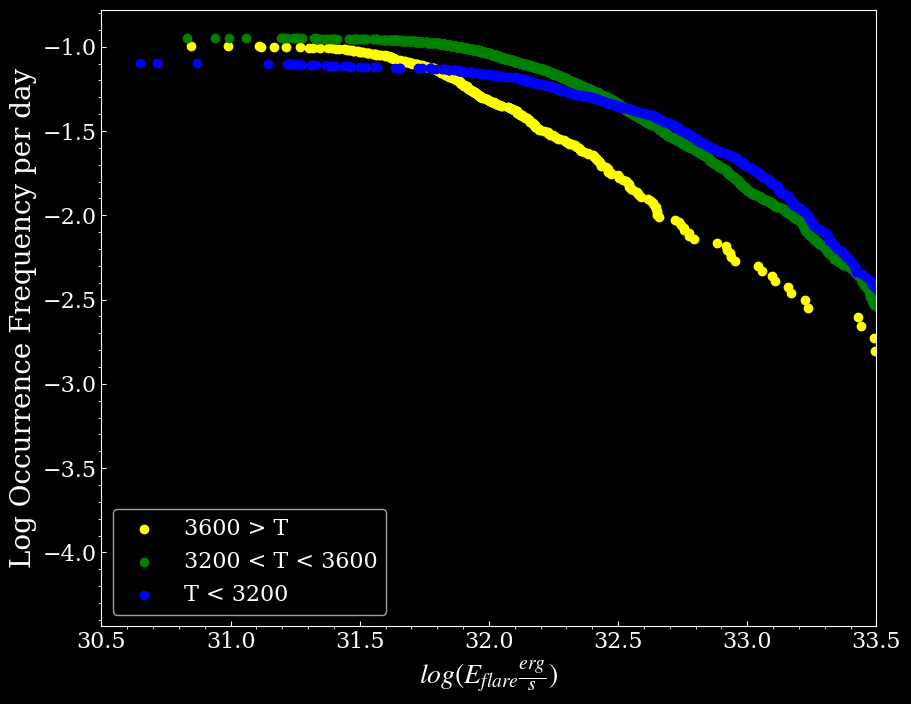

In [630]:
#OK, frequency plots!

flare_energies = flare_energies[flare_energies > 0]

cum_flare_freqs = cumulative_flare_count / total_time_of_observation

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value), np.log10(cum_flare_freqs), color = 'dodgerblue')
#plt.plot((31.8, 32.8), (-0.7, -2.4), linestyle = '--', color = 'black', label = 'Petrucci Line of Best Fit')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
plt.xlim(30.7, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()



flare_energies_low_temp = flare_energies_low_temp[flare_energies_low_temp > 0]

cum_flare_freqs_low_temp = cumulative_flare_count_low_temp / time_of_observation_low_temp

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_low_temp),
            np.log10(cum_flare_freqs_low_temp), color = 'blue', label = 'T < 3200')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()



flare_energies_mid_temp = flare_energies_mid_temp[flare_energies_mid_temp > 0]

cum_flare_freqs_mid_temp = cumulative_flare_count_mid_temp / time_of_observation_mid_temp

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_mid_temp),
            np.log10(cum_flare_freqs_mid_temp), color = 'green', label = '3200 < T < 3600')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()




flare_energies_high_temp = flare_energies_high_temp[flare_energies_high_temp > 0]


cum_flare_freqs_high_temp = cumulative_flare_count_high_temp / time_of_observation_high_temp

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_high_temp),
            np.log10(cum_flare_freqs_high_temp), color = 'yellow', label = '3600 > T')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()



plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_high_temp),
            np.log10(cum_flare_freqs_high_temp), color = 'yellow', label = '3600 > T')
plt.scatter(np.log10(cumulative_flare_value_mid_temp),
            np.log10(cum_flare_freqs_mid_temp), color = 'green', label = '3200 < T < 3600')
plt.scatter(np.log10(cumulative_flare_value_low_temp),
            np.log10(cum_flare_freqs_low_temp), color = 'blue', label = 'T < 3200')
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.legend()
plt.show()

## Best fitting for the new flares

In [632]:
# Defining the linear function

def linear_regression(log_E, params):

    m = params[0]

    c = params[1]

    return m * log_E + c

# Flare frequency fit

#initialize the guesses randomly around the correct ones to see if they converge

#only include the stuff with greater log(E) 32.2

power_law_min_log_energy = 32.4

power_law_region = np.where((np.log10(cumulative_flare_value) > power_law_min_log_energy))[0]

x_data_flares = np.log10(cumulative_flare_value[power_law_region])

y_data_flares = np.log10(cum_flare_freqs)[power_law_region]

#Use poly fit

flares_tot_ideal_parameters = np.polyfit(x_data_flares, y_data_flares, 1)

#Keep in mind the alpha is α = 1 - m from the equation above

alpha_flare = 1 - flares_tot_ideal_parameters[0]

###############CHECK THESE VALUES FOR ENERGY BOUNDS LATER!!!!##################
#For the low temp flares
#only include the stuff with greater log(E) 32.8

power_law_min_log_energy_low_temp = 32.8

low_temp_power_law_region = np.where(np.log10(cumulative_flare_value_low_temp) > power_law_min_log_energy_low_temp)[0]

x_data_low_temp = np.log10(cumulative_flare_value_low_temp[low_temp_power_law_region])

y_data_low_temp = np.log10(cum_flare_freqs_low_temp)[low_temp_power_law_region]

#Use poly fit

low_temp_ideal_parameters = np.polyfit(x_data_low_temp, y_data_low_temp, 1)


#Keep in mind the alpha is α = 1 - m from the equation above

alpha_low_temp = 1 - low_temp_ideal_parameters[0]


###############CHECK THESE VALUES FOR ENERGY BOUNDS LATER!!!!##################
#For the mid temp flares
#only include the stuff with greater log(E) 32.5

power_law_min_log_energy_mid_temp = 32.5

mid_temp_power_law_region = np.where(np.log10(cumulative_flare_value_mid_temp) > power_law_min_log_energy_mid_temp)[0]

x_data_mid_temp = np.log10(cumulative_flare_value_mid_temp[mid_temp_power_law_region])

y_data_mid_temp = np.log10(cum_flare_freqs_mid_temp)[mid_temp_power_law_region]

#Use poly fit

mid_temp_ideal_parameters = np.polyfit(x_data_mid_temp, y_data_mid_temp, 1)


#Keep in mind the alpha is α = 1 - m from the equation above

alpha_mid_temp = 1 - mid_temp_ideal_parameters[0]

###############CHECK THESE VALUES FOR ENERGY BOUNDS LATER!!!!##################
#For the high temp flares
#only include the stuff with greater log(E) 31.8

power_law_min_log_energy_high_temp = 31.8

high_temp_power_law_region = np.where(np.log10(cumulative_flare_value_high_temp) > power_law_min_log_energy_mid_temp)[0]

x_data_high_temp = np.log10(cumulative_flare_value_high_temp[high_temp_power_law_region])

y_data_high_temp = np.log10(cum_flare_freqs_high_temp)[high_temp_power_law_region]

#Use poly fit

high_temp_ideal_parameters = np.polyfit(x_data_high_temp, y_data_high_temp, 1)


#Keep in mind the alpha is α = 1 - m from the equation above

alpha_high_temp = 1 - high_temp_ideal_parameters[0]


# The END!

Finally, the last plots showing the flare frequency as well as their lines of best fit gained through MCMC!

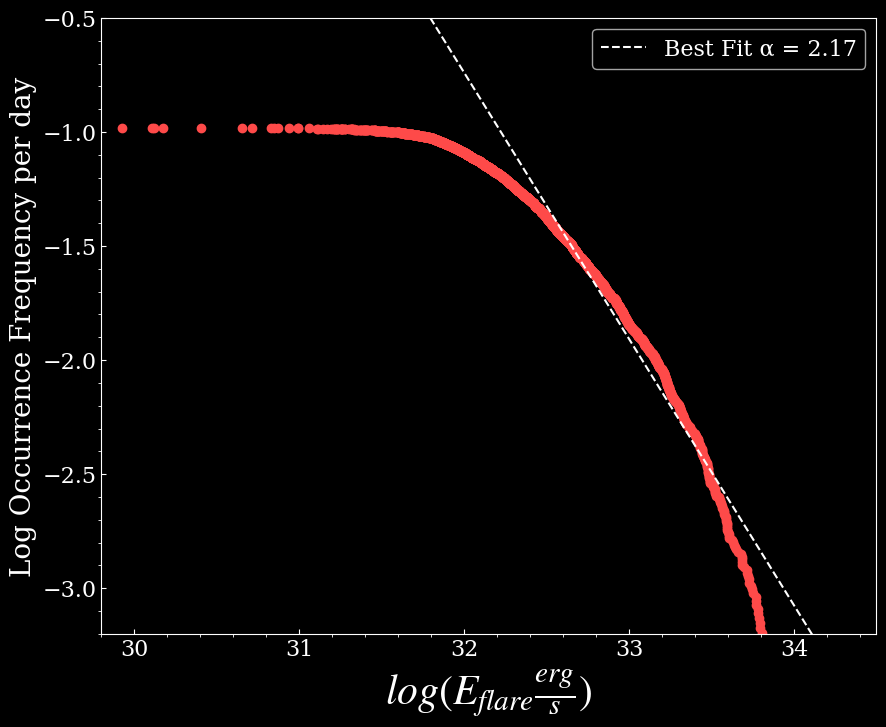

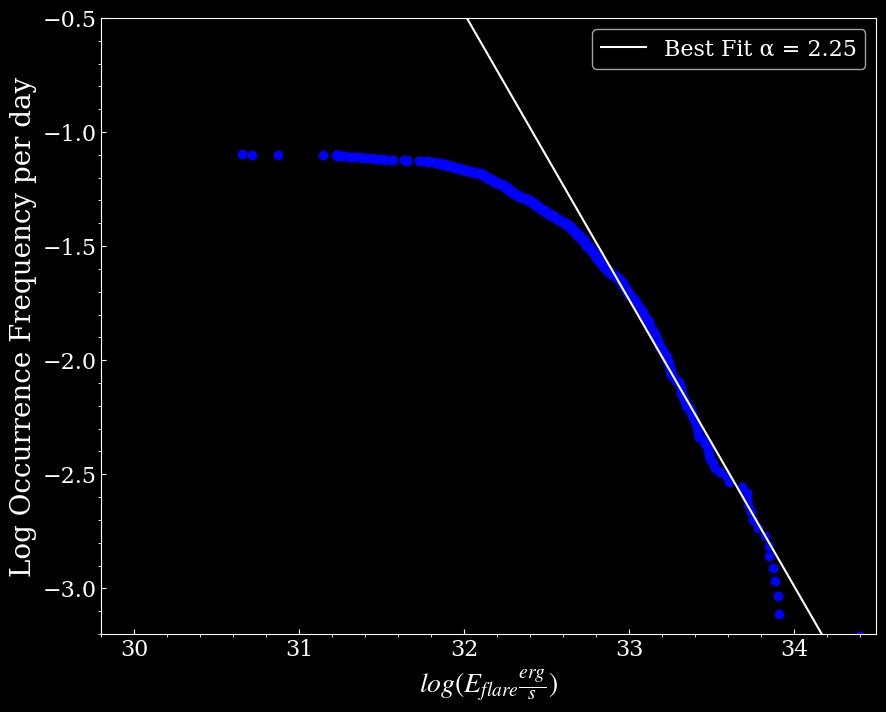

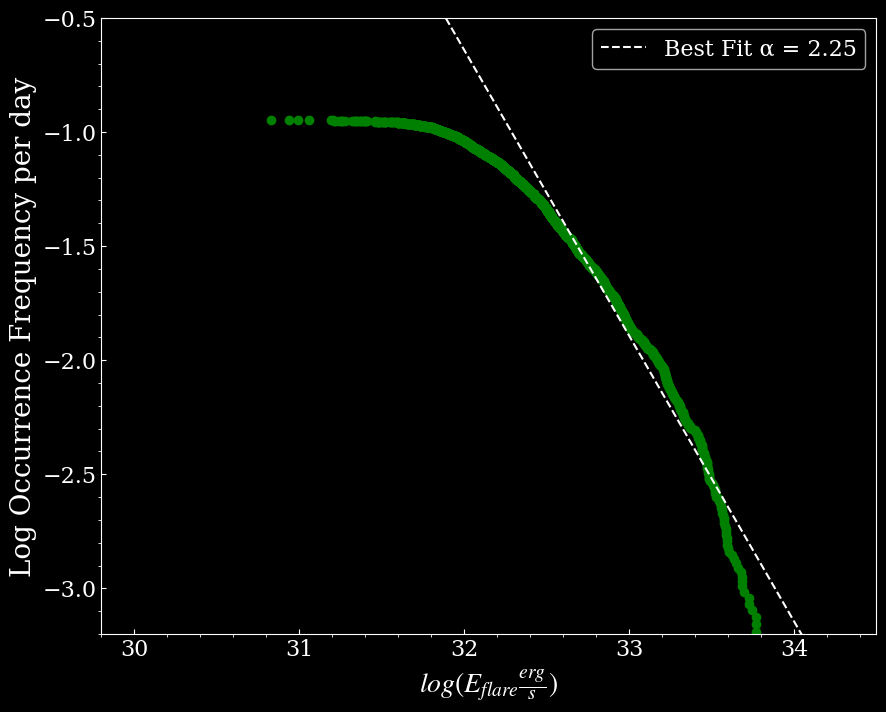

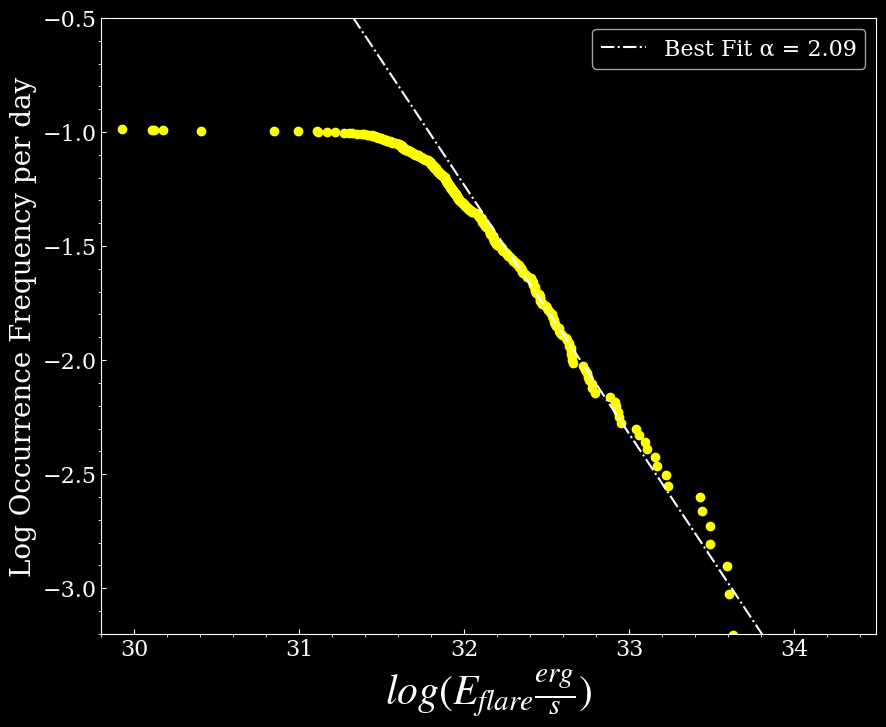

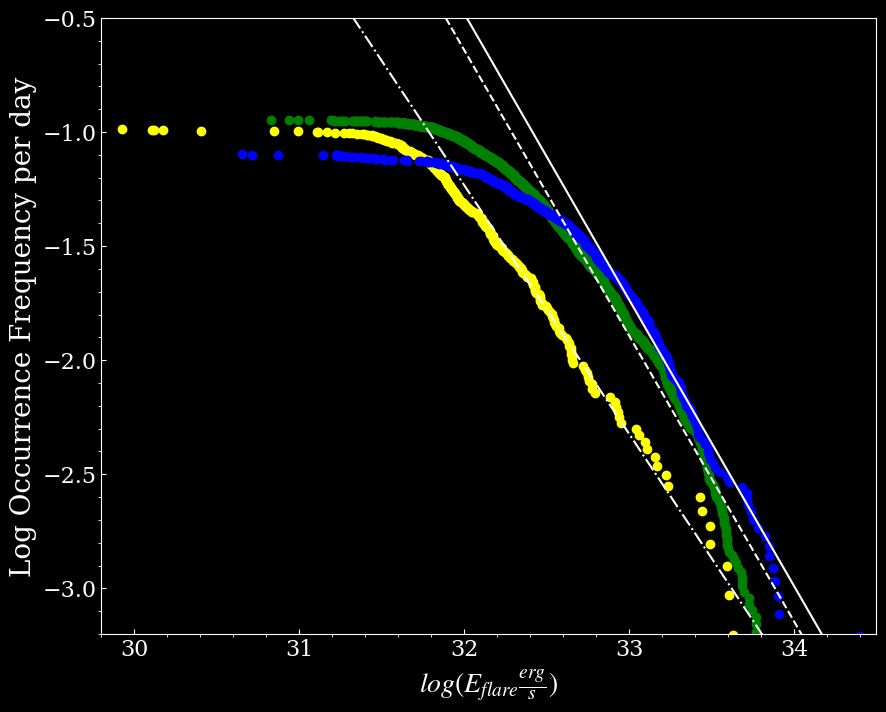

In [669]:
#OK, frequency plots!

#fit all the flares

log_E = np.linspace(29.5, 36.5, 100)

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value), np.log10(cum_flare_freqs), color = '#FE4A49')
plt.plot(log_E, linear_regression(log_E, flares_tot_ideal_parameters), linestyle = '--', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_flare, 2)))
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 30)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.7, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.ylim(-3.2, -0.5)
plt.xlim(29.8, 34.5)
plt.legend()
plt.show()



flare_energies_low_temp = flare_energies_low_temp[flare_energies_low_temp > 0]

log_flare_freqs_low_temp = cumulative_flare_count_low_temp / time_of_observation_low_temp

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_low_temp),
            np.log10(cum_flare_freqs_low_temp), color = 'blue')
plt.plot(log_E, linear_regression(log_E, low_temp_ideal_parameters), linestyle = '-', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_low_temp, 2)))
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.ylim(-3.2, -0.5)
plt.xlim(29.8, 34.5)
plt.legend()
plt.show()



flare_energies_mid_temp = flare_energies_mid_temp[flare_energies_mid_temp > 0]

log_flare_freqs_mid_temp = cumulative_flare_count_mid_temp / time_of_observation_mid_temp

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_mid_temp),
            np.log10(cum_flare_freqs_mid_temp), color = 'green')
plt.plot(log_E, linear_regression(log_E, mid_temp_ideal_parameters), linestyle = '--', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_mid_temp, 2)))
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.ylim(-3.2, -0.5)
plt.xlim(29.8, 34.5)
plt.legend()
plt.show()




flare_energies_high_temp = flare_energies_high_temp[flare_energies_high_temp > 0]


log_flare_freqs_high_temp = cumulative_flare_count_high_temp / time_of_observation_high_temp

plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_high_temp),
            np.log10(cum_flare_freqs_high_temp), color = 'yellow')
plt.plot(log_E, linear_regression(log_E, high_temp_ideal_parameters), linestyle = '-.', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_high_temp, 2)))
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 30)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.5)
#plt.ylim(-2.5, 0.75)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.ylim(-3.2, -0.5)
plt.xlim(29.8, 34.5)
plt.legend()
plt.show()



plt.figure(figsize = (10,8))

plt.scatter(np.log10(cumulative_flare_value_high_temp),
            np.log10(cum_flare_freqs_high_temp), color = 'yellow')
plt.scatter(np.log10(cumulative_flare_value_mid_temp),
            np.log10(cum_flare_freqs_mid_temp), color = 'green')
plt.scatter(np.log10(cumulative_flare_value_low_temp),
            np.log10(cum_flare_freqs_low_temp), color = 'blue')
plt.plot(log_E, linear_regression(log_E, low_temp_ideal_parameters), linestyle = '-', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_low_temp, 2)))
plt.plot(log_E, linear_regression(log_E, mid_temp_ideal_parameters), linestyle = '--', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_mid_temp, 2)))
plt.plot(log_E, linear_regression(log_E, high_temp_ideal_parameters), linestyle = '-.', color = 'white',
         label = 'Best Fit α = ' + str(round(alpha_high_temp, 2)))
plt.xlabel(r'$log(E_{flare} \frac{erg}{s})$', fontsize = 20)
plt.ylabel(r'Log Occurrence Frequency per day', fontsize = 20)
#plt.xlim(30.5, 33.2)
plt.minorticks_on()
plt.tick_params(direction = 'in', labelsize = 16)
plt.ylim(-3.2, -0.5)
plt.xlim(29.8, 34.5)
#plt.legend()
plt.show()

# Bootstrapping Uncertainties

In [636]:

# Bootstrapping the full sample

N_samples = 100


flare_freqs_sigma = bootstrapping_CFF_sigma(cumulative_flare_value, cum_flare_freqs,
                                            power_law_min_log_energy, N_samples)


#bootstrapping low temp sample

flare_freqs_low_temp_sigma = bootstrapping_CFF_sigma(cumulative_flare_value_low_temp, cum_flare_freqs_low_temp,
                                            power_law_min_log_energy_low_temp, N_samples)


#bootstrapping mid temp sample

flare_freqs_mid_temp_sigma = bootstrapping_CFF_sigma(cumulative_flare_value_mid_temp, cum_flare_freqs_mid_temp,
                                            power_law_min_log_energy_mid_temp, N_samples)

#bootstrapping high temp sample

flare_freqs_high_temp_sigma = bootstrapping_CFF_sigma(cumulative_flare_value_high_temp, cum_flare_freqs_high_temp,
                                            power_law_min_log_energy_high_temp, N_samples)

## Print Final Outputs

In [638]:
print('The best fit slope of the power law for all the flares is ' + str(round(alpha_flare, 2))
    + ' ± ' + str(round(flare_freqs_sigma, 2)))

print('')


print('The best fit slope of the power law for the low temp stuff is ' + str(round(alpha_low_temp, 2))
    + ' ± ' + str(round(flare_freqs_low_temp_sigma, 2)))

print('')

print('The best fit slope of the power law for the low temp stuff is ' + str(round(alpha_mid_temp, 2))
    + ' ± ' + str(round(flare_freqs_mid_temp_sigma, 2)))

print('')

print('The best fit slope of the power law for the low temp stuff is ' + str(round(alpha_high_temp, 2))
    + ' ± ' + str(round(flare_freqs_high_temp_sigma, 2)))

The best fit slope of the power law for all the flares is 2.17 ± 0.08

The best fit slope of the power law for the low temp stuff is 2.25 ± 0.06

The best fit slope of the power law for the low temp stuff is 2.25 ± 0.09

The best fit slope of the power law for the low temp stuff is 2.09 ± 0.04
